In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from sklearn.preprocessing import StandardScaler
from collections import deque
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
dataset= pd.read_csv('GOOG.csv')
dataset.sort_index(inplace=True)
dataset.index = dataset['Date']

del dataset['Date']
del dataset['Adj Close']
dataset = dataset.astype(float)

In [3]:
pre_day = 10
def Stock_Price_LSTM_Date_Precessing(dataset, memory_history_days,pre_days):
    dataset['label'] = dataset['Close'].shift(-pre_days)  # 向上移pre_day天
    dataset.dropna(inplace=True)
    # dataset
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(dataset.iloc[:,:-1])
    # sca_X
    # memory_history_days = 5


    deq  = deque(maxlen=memory_history_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq) == memory_history_days:
            X.append(list(deq))

    X_lately = X[-pre_day:]
    X = X[:-pre_day] # 去掉最后的 pre_day 天
    # print(len(X))
    # print(len(X_lately))

    y = dataset['label'].values[memory_history_days - 1 : -pre_day]  # 2005-01-07 : 2022-03-31
    # print(len(y))
    # print(y)
    X = np.array(X)
    y = np.array(y)
    # print(X.shape)
    # print(y.shape)
    return X,y,X_lately

In [4]:
X,y,X_lately = Stock_Price_LSTM_Date_Precessing(dataset,5,10)

In [5]:
print(len(X))
print(len(y))
print(len(X_lately))
print(y)

4328
4328
10
[  90.022575   88.229294   94.266663 ... 2865.       2852.889893
 2792.98999 ]


In [6]:
pre_days = 10
mem_days = [5,10,15]
lstm_layers = [1,2,3]
dense_layer = [1,2,3]
units = [16,32]

from keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layer:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_lstm_layers}_lstm_{the_lstm_layers}_dense_{the_lstm_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(filepath=filepath,
                                             save_weights_only = True,
                                             monitor='val_mape',
                                             mode='min',
                                             save_best_only=True)
                # print(filepath)
                X,y,X_lately = Stock_Price_LSTM_Date_Precessing(dataset,the_mem_days,pre_days)
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                model = Sequential()
                # 第一层
                model.add(LSTM(the_units, input_shape=X.shape[1:], activation='relu',return_sequences=True)) # 10个神经元   回归性质return_sequences=True
                model.add(Dropout(0.1)) # 防止过拟合，删除0.1%的神经元

                # 构建第二层
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units, activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                # 第三层
                model.add(LSTM(the_units, activation='relu'))
                model.add(Dropout(0.1))

                # 输出层
                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                # 编译
                model.compile(optimizer='adam', loss='mse', metrics=['mape'])

                model.fit(X_train, y_train,batch_size=32,epochs=50, validation_data=(X_test,y_test),callbacks=checkpoint) # epochs=50  50期训练

Epoch 1/50
122/122 [==============================] - 5s 11ms/step - loss: 310173.1250 - mape: 83.4867 - val_loss: 14893850.0000 - val_mape: 132.9204
Epoch 2/50
122/122 [==============================] - 1s 6ms/step - loss: 30684.7500 - mape: 27.9597 - val_loss: 1053731.5000 - val_mape: 32.1628
Epoch 3/50
122/122 [==============================] - 1s 6ms/step - loss: 17809.8691 - mape: 20.5558 - val_loss: 369263.1875 - val_mape: 19.0947
Epoch 4/50
122/122 [==============================] - 1s 7ms/step - loss: 15611.4883 - mape: 19.2101 - val_loss: 230340.3750 - val_mape: 15.2735
Epoch 5/50
122/122 [==============================] - 1s 6ms/step - loss: 15051.1094 - mape: 18.0420 - val_loss: 169518.5000 - val_mape: 13.2598
Epoch 6/50
122/122 [==============================] - 1s 6ms/step - loss: 14309.5264 - mape: 17.1044 - val_loss: 117878.3125 - val_mape: 11.2578
Epoch 7/50
122/122 [==============================] - 1s 6ms/step - loss: 12774.1982 - mape: 16.5203 - val_loss: 40618.3711 

Epoch 28/50
122/122 [==============================] - 1s 6ms/step - loss: 9206.5879 - mape: 13.3402 - val_loss: 165015.5781 - val_mape: 15.9471
Epoch 29/50
122/122 [==============================] - 1s 6ms/step - loss: 9038.5566 - mape: 13.6188 - val_loss: 251777.4375 - val_mape: 20.1190
Epoch 30/50
122/122 [==============================] - 1s 6ms/step - loss: 9071.6758 - mape: 13.1882 - val_loss: 241178.5000 - val_mape: 19.4583
Epoch 31/50
122/122 [==============================] - 1s 6ms/step - loss: 9192.8193 - mape: 13.3032 - val_loss: 341369.8125 - val_mape: 23.4015
Epoch 32/50
122/122 [==============================] - 1s 6ms/step - loss: 9009.7109 - mape: 13.1443 - val_loss: 246791.0000 - val_mape: 19.4313
Epoch 33/50
122/122 [==============================] - 1s 6ms/step - loss: 8895.8945 - mape: 12.9323 - val_loss: 293763.9375 - val_mape: 21.4188
Epoch 34/50
122/122 [==============================] - 1s 6ms/step - loss: 8416.8076 - mape: 12.8550 - val_loss: 126374.9297 - val

Epoch 5/50
122/122 [==============================] - 1s 6ms/step - loss: 10217.3105 - mape: 16.9652 - val_loss: 951687.7500 - val_mape: 27.8000
Epoch 6/50
122/122 [==============================] - 1s 6ms/step - loss: 9961.0332 - mape: 15.5674 - val_loss: 456914.0312 - val_mape: 20.2694
Epoch 7/50
122/122 [==============================] - 1s 6ms/step - loss: 8585.3174 - mape: 14.2327 - val_loss: 681531.3750 - val_mape: 23.4297
Epoch 8/50
122/122 [==============================] - 1s 6ms/step - loss: 7947.9067 - mape: 13.4593 - val_loss: 830800.6250 - val_mape: 26.7526
Epoch 9/50
122/122 [==============================] - 1s 7ms/step - loss: 7552.1074 - mape: 13.0207 - val_loss: 462223.7500 - val_mape: 19.2972
Epoch 10/50
122/122 [==============================] - 1s 6ms/step - loss: 7142.5781 - mape: 12.8701 - val_loss: 398550.6875 - val_mape: 17.9569
Epoch 11/50
122/122 [==============================] - 1s 6ms/step - loss: 7142.4937 - mape: 12.5888 - val_loss: 312254.8438 - val_map

Epoch 32/50
122/122 [==============================] - 1s 7ms/step - loss: 6197.8540 - mape: 11.0841 - val_loss: 25509.2891 - val_mape: 5.8369
Epoch 33/50
122/122 [==============================] - 1s 8ms/step - loss: 6275.3818 - mape: 11.1801 - val_loss: 27253.3379 - val_mape: 6.5113
Epoch 34/50
122/122 [==============================] - 1s 6ms/step - loss: 6604.1631 - mape: 11.0817 - val_loss: 53659.4805 - val_mape: 9.3864
Epoch 35/50
122/122 [==============================] - 1s 7ms/step - loss: 5820.9883 - mape: 10.6314 - val_loss: 82648.1562 - val_mape: 11.8728
Epoch 36/50
122/122 [==============================] - 1s 7ms/step - loss: 6082.5317 - mape: 10.8508 - val_loss: 20042.5938 - val_mape: 5.0696
Epoch 37/50
122/122 [==============================] - 1s 7ms/step - loss: 6327.3862 - mape: 10.7981 - val_loss: 19956.9043 - val_mape: 5.2888
Epoch 38/50
122/122 [==============================] - 1s 7ms/step - loss: 7320.3467 - mape: 11.3564 - val_loss: 79658.3828 - val_mape: 11.73

Epoch 9/50
121/121 [==============================] - 1s 6ms/step - loss: 14637.4600 - mape: 17.4667 - val_loss: 127845.3125 - val_mape: 13.0487
Epoch 10/50
121/121 [==============================] - 1s 6ms/step - loss: 14636.2637 - mape: 17.1693 - val_loss: 118979.8203 - val_mape: 12.3697
Epoch 11/50
121/121 [==============================] - 1s 6ms/step - loss: 13453.5967 - mape: 16.7538 - val_loss: 95065.7969 - val_mape: 11.7221
Epoch 12/50
121/121 [==============================] - 1s 6ms/step - loss: 14317.1738 - mape: 16.1698 - val_loss: 96896.3750 - val_mape: 10.7906
Epoch 13/50
121/121 [==============================] - 1s 6ms/step - loss: 12401.5938 - mape: 15.8823 - val_loss: 66011.4453 - val_mape: 11.3168
Epoch 14/50
121/121 [==============================] - 1s 6ms/step - loss: 12515.6377 - mape: 15.7309 - val_loss: 59041.1523 - val_mape: 10.5135
Epoch 15/50
121/121 [==============================] - 1s 6ms/step - loss: 11804.8018 - mape: 15.1997 - val_loss: 97060.8750 - va

Epoch 36/50
121/121 [==============================] - 1s 7ms/step - loss: 9329.9629 - mape: 13.4522 - val_loss: 198322.5312 - val_mape: 19.8027
Epoch 37/50
121/121 [==============================] - 1s 7ms/step - loss: 9341.8730 - mape: 13.1014 - val_loss: 293100.4375 - val_mape: 24.0117
Epoch 38/50
121/121 [==============================] - 1s 6ms/step - loss: 9572.8457 - mape: 13.5306 - val_loss: 228607.8750 - val_mape: 21.1886
Epoch 39/50
121/121 [==============================] - 1s 7ms/step - loss: 9105.8887 - mape: 13.0143 - val_loss: 197658.7344 - val_mape: 19.7603
Epoch 40/50
121/121 [==============================] - 1s 6ms/step - loss: 8851.2568 - mape: 13.0013 - val_loss: 207326.2812 - val_mape: 20.1953
Epoch 41/50
121/121 [==============================] - 1s 7ms/step - loss: 9174.2227 - mape: 13.0986 - val_loss: 264437.2500 - val_mape: 22.6089
Epoch 42/50
121/121 [==============================] - 1s 6ms/step - loss: 9091.0381 - mape: 13.0629 - val_loss: 254346.2188 - val

Epoch 13/50
121/121 [==============================] - 1s 7ms/step - loss: 9194.3613 - mape: 13.4495 - val_loss: 19721.9609 - val_mape: 5.1969
Epoch 14/50
121/121 [==============================] - 1s 7ms/step - loss: 9620.3945 - mape: 13.7732 - val_loss: 78234.8906 - val_mape: 10.6971
Epoch 15/50
121/121 [==============================] - 1s 7ms/step - loss: 9058.2041 - mape: 13.2952 - val_loss: 170832.9688 - val_mape: 16.0614
Epoch 16/50
121/121 [==============================] - 1s 7ms/step - loss: 9002.7266 - mape: 13.3312 - val_loss: 161180.7812 - val_mape: 15.8526
Epoch 17/50
121/121 [==============================] - 1s 7ms/step - loss: 8960.1553 - mape: 13.3798 - val_loss: 64544.3398 - val_mape: 9.2500
Epoch 18/50
121/121 [==============================] - 1s 7ms/step - loss: 9469.9062 - mape: 13.7053 - val_loss: 166821.3750 - val_mape: 15.9815
Epoch 19/50
121/121 [==============================] - 1s 7ms/step - loss: 8381.2051 - mape: 12.8832 - val_loss: 69341.8281 - val_mape:

Epoch 40/50
121/121 [==============================] - 1s 7ms/step - loss: 8462.9502 - mape: 12.4205 - val_loss: 411223.7500 - val_mape: 25.2782
Epoch 41/50
121/121 [==============================] - 1s 7ms/step - loss: 8252.0244 - mape: 12.0053 - val_loss: 212819.4844 - val_mape: 16.9801
Epoch 42/50
121/121 [==============================] - 1s 7ms/step - loss: 8359.8115 - mape: 12.5231 - val_loss: 306251.5000 - val_mape: 20.0454
Epoch 43/50
121/121 [==============================] - 1s 7ms/step - loss: 7730.8242 - mape: 11.9675 - val_loss: 179403.5000 - val_mape: 14.2481
Epoch 44/50
121/121 [==============================] - 1s 7ms/step - loss: 8510.3760 - mape: 12.3321 - val_loss: 419268.4688 - val_mape: 24.9136
Epoch 45/50
121/121 [==============================] - 1s 8ms/step - loss: 8170.3569 - mape: 12.3060 - val_loss: 181483.3750 - val_mape: 14.8942
Epoch 46/50
121/121 [==============================] - 1s 7ms/step - loss: 7823.0483 - mape: 12.0732 - val_loss: 217720.4219 - val

Epoch 17/50
121/121 [==============================] - 1s 6ms/step - loss: 10176.5557 - mape: 14.1447 - val_loss: 416059.5625 - val_mape: 27.5510
Epoch 18/50
121/121 [==============================] - 1s 6ms/step - loss: 10792.6035 - mape: 14.3668 - val_loss: 523640.1250 - val_mape: 31.2206
Epoch 19/50
121/121 [==============================] - 1s 6ms/step - loss: 10260.7148 - mape: 13.7500 - val_loss: 562840.5000 - val_mape: 32.1605
Epoch 20/50
121/121 [==============================] - 1s 6ms/step - loss: 10207.2383 - mape: 13.9542 - val_loss: 805603.9375 - val_mape: 38.6279
Epoch 21/50
121/121 [==============================] - 1s 6ms/step - loss: 8677.9395 - mape: 13.2082 - val_loss: 555241.2500 - val_mape: 31.8122
Epoch 22/50
121/121 [==============================] - 1s 6ms/step - loss: 9315.4902 - mape: 13.4382 - val_loss: 493813.9062 - val_mape: 29.7895
Epoch 23/50
121/121 [==============================] - 1s 6ms/step - loss: 9506.5332 - mape: 12.9837 - val_loss: 619200.0625 -

Epoch 44/50
121/121 [==============================] - 1s 8ms/step - loss: 8131.1206 - mape: 12.3689 - val_loss: 595603.9375 - val_mape: 32.7309
Epoch 45/50
121/121 [==============================] - 1s 8ms/step - loss: 8510.5742 - mape: 12.3568 - val_loss: 693599.8750 - val_mape: 35.5054
Epoch 46/50
121/121 [==============================] - 1s 7ms/step - loss: 8440.1689 - mape: 12.3298 - val_loss: 619803.1250 - val_mape: 33.4390
Epoch 47/50
121/121 [==============================] - 1s 7ms/step - loss: 8622.2314 - mape: 12.7466 - val_loss: 879846.5625 - val_mape: 39.9328
Epoch 48/50
121/121 [==============================] - 1s 7ms/step - loss: 7629.9858 - mape: 12.0516 - val_loss: 844350.5625 - val_mape: 39.5162
Epoch 49/50
121/121 [==============================] - 1s 7ms/step - loss: 7616.8809 - mape: 12.1011 - val_loss: 650912.1250 - val_mape: 34.2161
Epoch 50/50
121/121 [==============================] - 1s 7ms/step - loss: 6998.2808 - mape: 11.6448 - val_loss: 721439.1250 - val

Epoch 21/50
121/121 [==============================] - 1s 8ms/step - loss: 8209.7266 - mape: 12.6645 - val_loss: 622054.0000 - val_mape: 31.6800
Epoch 22/50
121/121 [==============================] - 1s 8ms/step - loss: 7363.7095 - mape: 12.3566 - val_loss: 657152.4375 - val_mape: 32.7013
Epoch 23/50
121/121 [==============================] - 1s 8ms/step - loss: 7625.3970 - mape: 12.2377 - val_loss: 479142.8125 - val_mape: 27.0180
Epoch 24/50
121/121 [==============================] - 1s 8ms/step - loss: 7644.4185 - mape: 12.2062 - val_loss: 656876.9375 - val_mape: 33.7558
Epoch 25/50
121/121 [==============================] - 1s 8ms/step - loss: 8001.4180 - mape: 12.1025 - val_loss: 537895.0000 - val_mape: 29.5944
Epoch 26/50
121/121 [==============================] - 1s 8ms/step - loss: 6967.2036 - mape: 11.9146 - val_loss: 760394.1875 - val_mape: 35.2892
Epoch 27/50
121/121 [==============================] - 1s 8ms/step - loss: 6937.1396 - mape: 11.8366 - val_loss: 756938.3125 - val

Epoch 48/50
121/121 [==============================] - 1s 8ms/step - loss: 6423.4048 - mape: 11.0143 - val_loss: 421862.3750 - val_mape: 24.3528
Epoch 49/50
121/121 [==============================] - 1s 9ms/step - loss: 7769.4663 - mape: 11.8569 - val_loss: 564036.2500 - val_mape: 30.8114
Epoch 50/50
121/121 [==============================] - 1s 8ms/step - loss: 6003.7129 - mape: 10.5957 - val_loss: 621535.1875 - val_mape: 31.8770
Epoch 1/50
120/120 [==============================] - 5s 12ms/step - loss: 327077.4062 - mape: 88.9833 - val_loss: 18421586.0000 - val_mape: 129.0038
Epoch 2/50
120/120 [==============================] - 1s 7ms/step - loss: 26524.5137 - mape: 27.6966 - val_loss: 1046516.1875 - val_mape: 27.8354
Epoch 3/50
120/120 [==============================] - 1s 7ms/step - loss: 15774.8330 - mape: 18.6955 - val_loss: 865512.3125 - val_mape: 25.2682
Epoch 4/50
120/120 [==============================] - 1s 7ms/step - loss: 15413.1504 - mape: 18.4562 - val_loss: 328006.5000

Epoch 25/50
120/120 [==============================] - 1s 8ms/step - loss: 11161.7871 - mape: 15.3532 - val_loss: 42487.5625 - val_mape: 8.3380
Epoch 26/50
120/120 [==============================] - 1s 8ms/step - loss: 11437.1387 - mape: 15.2254 - val_loss: 63424.9961 - val_mape: 12.0664
Epoch 27/50
120/120 [==============================] - 1s 8ms/step - loss: 10837.4414 - mape: 15.0738 - val_loss: 28623.6836 - val_mape: 6.6871
Epoch 28/50
120/120 [==============================] - 1s 8ms/step - loss: 10388.3662 - mape: 14.5108 - val_loss: 40127.2305 - val_mape: 9.1020
Epoch 29/50
120/120 [==============================] - 1s 8ms/step - loss: 11006.7549 - mape: 14.8880 - val_loss: 57909.4688 - val_mape: 10.8036
Epoch 30/50
120/120 [==============================] - 1s 8ms/step - loss: 10044.5615 - mape: 14.0823 - val_loss: 23791.7676 - val_mape: 6.0411
Epoch 31/50
120/120 [==============================] - 1s 8ms/step - loss: 10831.4482 - mape: 14.5793 - val_loss: 25277.1289 - val_map

Epoch 2/50
120/120 [==============================] - 1s 10ms/step - loss: 16725.9258 - mape: 21.2979 - val_loss: 1791280.2500 - val_mape: 37.2846
Epoch 3/50
120/120 [==============================] - 1s 8ms/step - loss: 12015.2227 - mape: 18.5465 - val_loss: 742770.7500 - val_mape: 24.3053
Epoch 4/50
120/120 [==============================] - 1s 8ms/step - loss: 10551.5498 - mape: 16.5086 - val_loss: 766478.6250 - val_mape: 24.3295
Epoch 5/50
120/120 [==============================] - 1s 8ms/step - loss: 9997.9531 - mape: 15.4445 - val_loss: 347521.4062 - val_mape: 17.6468
Epoch 6/50
120/120 [==============================] - 1s 9ms/step - loss: 8817.8057 - mape: 14.4564 - val_loss: 359210.0938 - val_mape: 17.2682
Epoch 7/50
120/120 [==============================] - 1s 8ms/step - loss: 8283.4717 - mape: 13.9368 - val_loss: 244486.4375 - val_mape: 14.5756
Epoch 8/50
120/120 [==============================] - 1s 8ms/step - loss: 9004.9717 - mape: 13.8392 - val_loss: 93040.3984 - val_ma

Epoch 29/50
120/120 [==============================] - 1s 10ms/step - loss: 7363.8096 - mape: 12.2979 - val_loss: 80918.0078 - val_mape: 13.4194
Epoch 30/50
120/120 [==============================] - 1s 10ms/step - loss: 7120.4194 - mape: 12.3713 - val_loss: 31254.2109 - val_mape: 8.0904
Epoch 31/50
120/120 [==============================] - 1s 9ms/step - loss: 6556.4448 - mape: 12.3206 - val_loss: 77086.6016 - val_mape: 13.2390
Epoch 32/50
120/120 [==============================] - 1s 9ms/step - loss: 7094.1899 - mape: 12.1988 - val_loss: 58434.7969 - val_mape: 10.9547
Epoch 33/50
120/120 [==============================] - 1s 9ms/step - loss: 6597.0938 - mape: 12.1076 - val_loss: 58805.7148 - val_mape: 11.2872
Epoch 34/50
120/120 [==============================] - 1s 9ms/step - loss: 7230.4087 - mape: 12.2262 - val_loss: 146460.2188 - val_mape: 18.2658
Epoch 35/50
120/120 [==============================] - 1s 9ms/step - loss: 6608.3721 - mape: 12.1262 - val_loss: 39957.4492 - val_mape

Epoch 6/50
120/120 [==============================] - 1s 7ms/step - loss: 18142.4492 - mape: 20.8284 - val_loss: 296206.9062 - val_mape: 17.1401
Epoch 7/50
120/120 [==============================] - 1s 7ms/step - loss: 17121.4121 - mape: 20.3119 - val_loss: 142177.3438 - val_mape: 15.5588
Epoch 8/50
120/120 [==============================] - 1s 7ms/step - loss: 16369.6035 - mape: 19.5482 - val_loss: 93285.4141 - val_mape: 13.7933
Epoch 9/50
120/120 [==============================] - 1s 7ms/step - loss: 16200.5273 - mape: 19.4943 - val_loss: 103481.5547 - val_mape: 13.1240
Epoch 10/50
120/120 [==============================] - 1s 7ms/step - loss: 16140.4980 - mape: 19.5208 - val_loss: 75109.0547 - val_mape: 13.3915
Epoch 11/50
120/120 [==============================] - 1s 7ms/step - loss: 14658.8428 - mape: 18.4618 - val_loss: 65902.8906 - val_mape: 12.1095
Epoch 12/50
120/120 [==============================] - 1s 7ms/step - loss: 15698.9238 - mape: 18.8645 - val_loss: 57494.9922 - val_

120/120 [==============================] - 1s 8ms/step - loss: 10323.8672 - mape: 14.8482 - val_loss: 659500.2500 - val_mape: 37.1046
Epoch 33/50
120/120 [==============================] - 1s 8ms/step - loss: 10265.9961 - mape: 14.7798 - val_loss: 449123.6562 - val_mape: 30.3532
Epoch 34/50
120/120 [==============================] - 1s 9ms/step - loss: 10452.1758 - mape: 14.5843 - val_loss: 403146.0312 - val_mape: 28.5084
Epoch 35/50
120/120 [==============================] - 1s 9ms/step - loss: 10202.3184 - mape: 14.4332 - val_loss: 445427.6875 - val_mape: 30.1779
Epoch 36/50
120/120 [==============================] - 1s 8ms/step - loss: 10133.3477 - mape: 14.5414 - val_loss: 390666.2500 - val_mape: 27.7959
Epoch 37/50
120/120 [==============================] - 1s 8ms/step - loss: 9778.7461 - mape: 14.5472 - val_loss: 485121.5625 - val_mape: 31.4432
Epoch 38/50
120/120 [==============================] - 1s 8ms/step - loss: 10038.5830 - mape: 13.9030 - val_loss: 236793.3906 - val_mape:

119/119 [==============================] - 1s 8ms/step - loss: 9933.1641 - mape: 15.6289 - val_loss: 94806.1016 - val_mape: 12.4859
Epoch 10/50
119/119 [==============================] - 1s 8ms/step - loss: 9209.5645 - mape: 14.9161 - val_loss: 84106.4688 - val_mape: 11.8637
Epoch 11/50
119/119 [==============================] - 1s 8ms/step - loss: 9434.5098 - mape: 14.8143 - val_loss: 62485.0703 - val_mape: 12.0541
Epoch 12/50
119/119 [==============================] - 1s 8ms/step - loss: 9612.3252 - mape: 14.7228 - val_loss: 63064.8398 - val_mape: 10.3406
Epoch 13/50
119/119 [==============================] - 1s 8ms/step - loss: 10071.1182 - mape: 15.1255 - val_loss: 46353.2578 - val_mape: 10.1970
Epoch 14/50
119/119 [==============================] - 1s 8ms/step - loss: 8938.9121 - mape: 14.3714 - val_loss: 56059.8281 - val_mape: 11.5398
Epoch 15/50
119/119 [==============================] - 1s 8ms/step - loss: 8596.5322 - mape: 14.2815 - val_loss: 54953.0547 - val_mape: 9.6953
Epoc

Epoch 36/50
119/119 [==============================] - 1s 9ms/step - loss: 7094.9082 - mape: 12.0640 - val_loss: 28427.5547 - val_mape: 7.8224
Epoch 37/50
119/119 [==============================] - 1s 9ms/step - loss: 7620.5557 - mape: 12.1965 - val_loss: 131712.2656 - val_mape: 18.2425
Epoch 38/50
119/119 [==============================] - 1s 9ms/step - loss: 7169.8374 - mape: 12.0156 - val_loss: 28541.3906 - val_mape: 7.9980
Epoch 39/50
119/119 [==============================] - 1s 10ms/step - loss: 7107.4653 - mape: 12.1389 - val_loss: 126495.9062 - val_mape: 17.5607
Epoch 40/50
119/119 [==============================] - 1s 10ms/step - loss: 6942.1846 - mape: 11.7589 - val_loss: 175718.4531 - val_mape: 20.6813
Epoch 41/50
119/119 [==============================] - 1s 9ms/step - loss: 6788.9092 - mape: 11.5843 - val_loss: 95893.3125 - val_mape: 15.4416
Epoch 42/50
119/119 [==============================] - 1s 9ms/step - loss: 6706.2437 - mape: 11.6042 - val_loss: 98997.0469 - val_map

Epoch 13/50
119/119 [==============================] - 1s 8ms/step - loss: 14558.3477 - mape: 16.8285 - val_loss: 89131.4609 - val_mape: 15.3337
Epoch 14/50
119/119 [==============================] - 1s 7ms/step - loss: 13320.9141 - mape: 16.6508 - val_loss: 97223.4531 - val_mape: 16.0937
Epoch 15/50
119/119 [==============================] - 1s 7ms/step - loss: 13126.9082 - mape: 16.9454 - val_loss: 96571.3906 - val_mape: 16.0108
Epoch 16/50
119/119 [==============================] - 1s 8ms/step - loss: 12658.3047 - mape: 16.2627 - val_loss: 141785.5938 - val_mape: 20.0417
Epoch 17/50
119/119 [==============================] - 1s 7ms/step - loss: 12597.4834 - mape: 16.0941 - val_loss: 186700.0938 - val_mape: 23.2495
Epoch 18/50
119/119 [==============================] - 1s 7ms/step - loss: 12714.0859 - mape: 16.1364 - val_loss: 72510.0391 - val_mape: 13.2825
Epoch 19/50
119/119 [==============================] - 1s 7ms/step - loss: 12385.4453 - mape: 16.3902 - val_loss: 103687.2812 - 

119/119 [==============================] - 1s 10ms/step - loss: 9832.4072 - mape: 13.9913 - val_loss: 169035.0469 - val_mape: 21.3902
Epoch 40/50
119/119 [==============================] - 1s 8ms/step - loss: 9754.3584 - mape: 14.0339 - val_loss: 260427.2969 - val_mape: 26.1271
Epoch 41/50
119/119 [==============================] - 1s 8ms/step - loss: 10308.6836 - mape: 14.4033 - val_loss: 215205.2656 - val_mape: 24.3521
Epoch 42/50
119/119 [==============================] - 1s 8ms/step - loss: 9469.3291 - mape: 13.8011 - val_loss: 271867.9688 - val_mape: 26.8096
Epoch 43/50
119/119 [==============================] - 1s 9ms/step - loss: 9523.5615 - mape: 13.5709 - val_loss: 243124.1094 - val_mape: 25.1828
Epoch 44/50
119/119 [==============================] - 1s 8ms/step - loss: 9129.0527 - mape: 13.8128 - val_loss: 170599.4375 - val_mape: 21.1878
Epoch 45/50
119/119 [==============================] - 1s 8ms/step - loss: 9121.3213 - mape: 13.4024 - val_loss: 176846.8281 - val_mape: 21.

119/119 [==============================] - 1s 9ms/step - loss: 7600.8008 - mape: 12.4841 - val_loss: 92280.0391 - val_mape: 13.7112
Epoch 17/50
119/119 [==============================] - 1s 9ms/step - loss: 7372.4189 - mape: 12.4419 - val_loss: 97893.7500 - val_mape: 13.4333
Epoch 18/50
119/119 [==============================] - 1s 9ms/step - loss: 7436.6304 - mape: 12.4193 - val_loss: 76251.8828 - val_mape: 13.0373
Epoch 19/50
119/119 [==============================] - 1s 9ms/step - loss: 7767.4307 - mape: 12.3175 - val_loss: 119539.2891 - val_mape: 13.3329
Epoch 20/50
119/119 [==============================] - 1s 8ms/step - loss: 7538.2661 - mape: 12.2263 - val_loss: 106792.4922 - val_mape: 13.9424
Epoch 21/50
119/119 [==============================] - 1s 8ms/step - loss: 7405.0283 - mape: 12.5130 - val_loss: 97891.3281 - val_mape: 16.2103
Epoch 22/50
119/119 [==============================] - 1s 8ms/step - loss: 8209.5527 - mape: 12.3953 - val_loss: 124014.4062 - val_mape: 14.9138
E

Epoch 43/50
119/119 [==============================] - 1s 9ms/step - loss: 5923.2451 - mape: 11.1165 - val_loss: 98565.4062 - val_mape: 16.3558
Epoch 44/50
119/119 [==============================] - 1s 9ms/step - loss: 5603.1987 - mape: 10.8506 - val_loss: 200736.3438 - val_mape: 23.7976
Epoch 45/50
119/119 [==============================] - 1s 9ms/step - loss: 5416.8516 - mape: 10.3033 - val_loss: 112012.7812 - val_mape: 17.7224
Epoch 46/50
119/119 [==============================] - 1s 8ms/step - loss: 5096.1382 - mape: 10.2859 - val_loss: 135965.6562 - val_mape: 19.6072
Epoch 47/50
119/119 [==============================] - 1s 8ms/step - loss: 5342.3579 - mape: 10.4745 - val_loss: 105393.6328 - val_mape: 16.4934
Epoch 48/50
119/119 [==============================] - 1s 9ms/step - loss: 5541.6196 - mape: 10.4351 - val_loss: 177666.2031 - val_mape: 22.8785
Epoch 49/50
119/119 [==============================] - 1s 8ms/step - loss: 5586.2397 - mape: 10.9781 - val_loss: 146464.5625 - val_

Epoch 20/50
119/119 [==============================] - 1s 9ms/step - loss: 11780.4766 - mape: 16.3522 - val_loss: 204439.0312 - val_mape: 14.3333
Epoch 21/50
119/119 [==============================] - 1s 8ms/step - loss: 12494.2910 - mape: 16.2884 - val_loss: 367085.0312 - val_mape: 18.4441
Epoch 22/50
119/119 [==============================] - 1s 9ms/step - loss: 11917.1416 - mape: 16.4355 - val_loss: 208551.1094 - val_mape: 14.4162
Epoch 23/50
119/119 [==============================] - 1s 8ms/step - loss: 13359.5508 - mape: 16.5521 - val_loss: 198596.5156 - val_mape: 14.2776
Epoch 24/50
119/119 [==============================] - 1s 9ms/step - loss: 12047.7236 - mape: 16.4271 - val_loss: 386675.9688 - val_mape: 19.2043
Epoch 25/50
119/119 [==============================] - 1s 9ms/step - loss: 11605.2090 - mape: 16.3371 - val_loss: 367989.6250 - val_mape: 18.8510
Epoch 26/50
119/119 [==============================] - 1s 9ms/step - loss: 12471.4199 - mape: 16.4826 - val_loss: 155840.968

119/119 [==============================] - 1s 9ms/step - loss: 11870.1533 - mape: 15.6476 - val_loss: 74517.6875 - val_mape: 9.8938
Epoch 47/50
119/119 [==============================] - 1s 9ms/step - loss: 12414.2129 - mape: 15.7937 - val_loss: 285472.9688 - val_mape: 17.0043
Epoch 48/50
119/119 [==============================] - 1s 9ms/step - loss: 11115.7207 - mape: 15.2670 - val_loss: 190306.1094 - val_mape: 13.3047
Epoch 49/50
119/119 [==============================] - 1s 10ms/step - loss: 11148.9902 - mape: 15.1348 - val_loss: 72793.5391 - val_mape: 11.0518
Epoch 50/50
119/119 [==============================] - 1s 10ms/step - loss: 10623.2715 - mape: 14.9608 - val_loss: 100641.4062 - val_mape: 10.9734
Epoch 1/50
118/118 [==============================] - 7s 16ms/step - loss: 220414.4062 - mape: 71.4723 - val_loss: 645777.0000 - val_mape: 25.2335
Epoch 2/50
118/118 [==============================] - 1s 10ms/step - loss: 12973.3174 - mape: 20.5234 - val_loss: 175984.4531 - val_mape

118/118 [==============================] - 1s 11ms/step - loss: 5875.5923 - mape: 11.7100 - val_loss: 18664.8984 - val_mape: 6.7525
Epoch 24/50
118/118 [==============================] - 1s 11ms/step - loss: 5680.4316 - mape: 11.5000 - val_loss: 13609.4893 - val_mape: 5.7166
Epoch 25/50
118/118 [==============================] - 1s 11ms/step - loss: 5676.6797 - mape: 11.7927 - val_loss: 21151.1973 - val_mape: 7.0336
Epoch 26/50
118/118 [==============================] - 1s 11ms/step - loss: 5337.0781 - mape: 11.1948 - val_loss: 51696.4062 - val_mape: 11.5253
Epoch 27/50
118/118 [==============================] - 1s 11ms/step - loss: 5323.0142 - mape: 11.2234 - val_loss: 50040.9023 - val_mape: 11.3177
Epoch 28/50
118/118 [==============================] - 1s 11ms/step - loss: 5686.9087 - mape: 11.4539 - val_loss: 14452.4619 - val_mape: 5.8312
Epoch 29/50
118/118 [==============================] - 1s 11ms/step - loss: 5281.8330 - mape: 11.1936 - val_loss: 19989.9746 - val_mape: 6.5214
Ep

Epoch 50/50
118/118 [==============================] - 1s 12ms/step - loss: 4686.2622 - mape: 10.2860 - val_loss: 55878.7266 - val_mape: 11.6766
Epoch 1/50
118/118 [==============================] - 7s 15ms/step - loss: 273766.5000 - mape: 88.3207 - val_loss: 9633472.0000 - val_mape: 113.0524
Epoch 2/50
118/118 [==============================] - 1s 9ms/step - loss: 44820.3594 - mape: 41.2361 - val_loss: 902213.8125 - val_mape: 30.7273
Epoch 3/50
118/118 [==============================] - 1s 9ms/step - loss: 26153.1484 - mape: 29.0563 - val_loss: 207551.9219 - val_mape: 16.0083
Epoch 4/50
118/118 [==============================] - 1s 9ms/step - loss: 22281.2656 - mape: 24.8551 - val_loss: 108637.8750 - val_mape: 13.5975
Epoch 5/50
118/118 [==============================] - 1s 9ms/step - loss: 20914.1660 - mape: 23.5984 - val_loss: 163150.4375 - val_mape: 14.2844
Epoch 6/50
118/118 [==============================] - 1s 9ms/step - loss: 18281.5000 - mape: 22.3797 - val_loss: 58390.1289 - 

118/118 [==============================] - 1s 10ms/step - loss: 9109.5635 - mape: 13.9486 - val_loss: 253067.5781 - val_mape: 26.1432
Epoch 27/50
118/118 [==============================] - 1s 10ms/step - loss: 9805.3252 - mape: 14.2904 - val_loss: 217049.8750 - val_mape: 23.9107
Epoch 28/50
118/118 [==============================] - 1s 10ms/step - loss: 9335.7852 - mape: 14.1114 - val_loss: 214635.9062 - val_mape: 23.9146
Epoch 29/50
118/118 [==============================] - 1s 10ms/step - loss: 8701.6523 - mape: 13.7559 - val_loss: 278514.8750 - val_mape: 27.0527
Epoch 30/50
118/118 [==============================] - 1s 10ms/step - loss: 8572.0068 - mape: 13.7565 - val_loss: 226232.1875 - val_mape: 24.0916
Epoch 31/50
118/118 [==============================] - 1s 10ms/step - loss: 8403.2764 - mape: 13.8889 - val_loss: 271032.5312 - val_mape: 26.6163
Epoch 32/50
118/118 [==============================] - 1s 9ms/step - loss: 8666.2842 - mape: 13.5085 - val_loss: 344686.8438 - val_mape:

118/118 [==============================] - 1s 10ms/step - loss: 16158.3223 - mape: 23.0012 - val_loss: 55375.3672 - val_mape: 10.5748
Epoch 4/50
118/118 [==============================] - 1s 10ms/step - loss: 15298.0029 - mape: 21.4536 - val_loss: 43100.6133 - val_mape: 10.9434
Epoch 5/50
118/118 [==============================] - 1s 10ms/step - loss: 13688.6855 - mape: 18.3354 - val_loss: 64689.4297 - val_mape: 13.7936
Epoch 6/50
118/118 [==============================] - 1s 10ms/step - loss: 9895.4717 - mape: 15.8017 - val_loss: 42813.1992 - val_mape: 10.9295
Epoch 7/50
118/118 [==============================] - 1s 10ms/step - loss: 9928.2334 - mape: 15.5573 - val_loss: 48179.2500 - val_mape: 11.6636
Epoch 8/50
118/118 [==============================] - 1s 10ms/step - loss: 8355.7510 - mape: 14.1884 - val_loss: 52294.4688 - val_mape: 12.2742
Epoch 9/50
118/118 [==============================] - 1s 10ms/step - loss: 8269.3066 - mape: 14.0248 - val_loss: 77402.1094 - val_mape: 15.1841


Epoch 30/50
118/118 [==============================] - 1s 11ms/step - loss: 6901.5967 - mape: 12.1466 - val_loss: 47021.8047 - val_mape: 10.9818
Epoch 31/50
118/118 [==============================] - 1s 11ms/step - loss: 6748.9756 - mape: 11.7693 - val_loss: 233392.0938 - val_mape: 24.1444
Epoch 32/50
118/118 [==============================] - 1s 11ms/step - loss: 6497.6333 - mape: 12.1468 - val_loss: 118215.8594 - val_mape: 17.8276
Epoch 33/50
118/118 [==============================] - 1s 11ms/step - loss: 6308.7725 - mape: 12.1228 - val_loss: 105989.1250 - val_mape: 16.5203
Epoch 34/50
118/118 [==============================] - 1s 11ms/step - loss: 6387.3101 - mape: 11.8460 - val_loss: 170723.3125 - val_mape: 20.8876
Epoch 35/50
118/118 [==============================] - 1s 11ms/step - loss: 6442.9458 - mape: 11.9027 - val_loss: 192005.8281 - val_mape: 22.2459
Epoch 36/50
118/118 [==============================] - 1s 11ms/step - loss: 6085.6182 - mape: 11.6853 - val_loss: 133255.4062

Epoch 7/50
117/117 [==============================] - 1s 9ms/step - loss: 17461.1895 - mape: 21.2096 - val_loss: 269931.6250 - val_mape: 27.9998
Epoch 8/50
117/117 [==============================] - 1s 9ms/step - loss: 15422.0205 - mape: 20.6587 - val_loss: 443679.4688 - val_mape: 36.2228
Epoch 9/50
117/117 [==============================] - 1s 9ms/step - loss: 14108.4365 - mape: 19.6711 - val_loss: 401370.1562 - val_mape: 34.1076
Epoch 10/50
117/117 [==============================] - 1s 9ms/step - loss: 13965.8174 - mape: 18.9891 - val_loss: 540903.3125 - val_mape: 39.8843
Epoch 11/50
117/117 [==============================] - 1s 9ms/step - loss: 13983.1377 - mape: 18.9129 - val_loss: 399874.3125 - val_mape: 34.1311
Epoch 12/50
117/117 [==============================] - 1s 9ms/step - loss: 12600.9424 - mape: 18.0022 - val_loss: 557271.3750 - val_mape: 40.2669
Epoch 13/50
117/117 [==============================] - 1s 9ms/step - loss: 12382.6865 - mape: 17.6355 - val_loss: 406143.3125 -

117/117 [==============================] - 1s 10ms/step - loss: 10014.1631 - mape: 14.6544 - val_loss: 645064.6250 - val_mape: 42.3709
Epoch 34/50
117/117 [==============================] - 1s 10ms/step - loss: 7931.3149 - mape: 13.6935 - val_loss: 683320.0000 - val_mape: 43.4845
Epoch 35/50
117/117 [==============================] - 1s 10ms/step - loss: 8037.5386 - mape: 13.5332 - val_loss: 641162.1250 - val_mape: 41.7561
Epoch 36/50
117/117 [==============================] - 1s 10ms/step - loss: 8862.0859 - mape: 14.0845 - val_loss: 643482.4375 - val_mape: 42.1701
Epoch 37/50
117/117 [==============================] - 1s 11ms/step - loss: 7645.9707 - mape: 13.6987 - val_loss: 703001.9375 - val_mape: 43.7312
Epoch 38/50
117/117 [==============================] - 1s 10ms/step - loss: 8024.8066 - mape: 13.4164 - val_loss: 718355.7500 - val_mape: 44.4062
Epoch 39/50
117/117 [==============================] - 1s 10ms/step - loss: 7713.6680 - mape: 13.4559 - val_loss: 703947.5625 - val_map

117/117 [==============================] - 1s 10ms/step - loss: 8957.4756 - mape: 14.1277 - val_loss: 203308.9531 - val_mape: 14.7808
Epoch 11/50
117/117 [==============================] - 1s 10ms/step - loss: 8271.3184 - mape: 13.6851 - val_loss: 87525.2812 - val_mape: 14.1843
Epoch 12/50
117/117 [==============================] - 1s 10ms/step - loss: 9524.4512 - mape: 14.6085 - val_loss: 81473.2422 - val_mape: 16.1140
Epoch 13/50
117/117 [==============================] - 1s 10ms/step - loss: 8634.2520 - mape: 13.7041 - val_loss: 59407.4297 - val_mape: 12.9946
Epoch 14/50
117/117 [==============================] - 1s 10ms/step - loss: 8655.3535 - mape: 13.9831 - val_loss: 57520.9688 - val_mape: 13.0218
Epoch 15/50
117/117 [==============================] - 1s 10ms/step - loss: 7603.2100 - mape: 13.2309 - val_loss: 74131.5000 - val_mape: 14.4197
Epoch 16/50
117/117 [==============================] - 1s 11ms/step - loss: 8292.8223 - mape: 13.1427 - val_loss: 121953.1250 - val_mape: 13.

Epoch 37/50
117/117 [==============================] - 1s 11ms/step - loss: 6950.3896 - mape: 12.3460 - val_loss: 61313.5000 - val_mape: 13.5948
Epoch 38/50
117/117 [==============================] - 1s 11ms/step - loss: 6459.7739 - mape: 12.1935 - val_loss: 65805.8906 - val_mape: 14.3487
Epoch 39/50
117/117 [==============================] - 1s 11ms/step - loss: 7332.8052 - mape: 12.3605 - val_loss: 79339.3047 - val_mape: 15.8438
Epoch 40/50
117/117 [==============================] - 1s 11ms/step - loss: 7290.7104 - mape: 12.6625 - val_loss: 72963.6562 - val_mape: 15.2106
Epoch 41/50
117/117 [==============================] - 1s 11ms/step - loss: 6965.5747 - mape: 12.1571 - val_loss: 117822.3984 - val_mape: 19.6251
Epoch 42/50
117/117 [==============================] - 1s 11ms/step - loss: 6224.3042 - mape: 11.6305 - val_loss: 85454.1328 - val_mape: 16.5549
Epoch 43/50
117/117 [==============================] - 1s 11ms/step - loss: 6463.7578 - mape: 12.0889 - val_loss: 79749.0547 - va

Epoch 14/50
117/117 [==============================] - 1s 9ms/step - loss: 10779.9727 - mape: 15.5204 - val_loss: 27615.7266 - val_mape: 8.9468
Epoch 15/50
117/117 [==============================] - 1s 9ms/step - loss: 11300.3496 - mape: 15.8360 - val_loss: 19663.2422 - val_mape: 7.1826
Epoch 16/50
117/117 [==============================] - 1s 9ms/step - loss: 10952.9541 - mape: 15.3492 - val_loss: 36373.7344 - val_mape: 10.1748
Epoch 17/50
117/117 [==============================] - 1s 9ms/step - loss: 11041.2959 - mape: 15.4092 - val_loss: 29775.2949 - val_mape: 9.0818
Epoch 18/50
117/117 [==============================] - 1s 9ms/step - loss: 10809.9199 - mape: 15.2760 - val_loss: 26697.9199 - val_mape: 8.3078
Epoch 19/50
117/117 [==============================] - 1s 9ms/step - loss: 11760.7246 - mape: 15.8127 - val_loss: 33034.8828 - val_mape: 9.5392
Epoch 20/50
117/117 [==============================] - 1s 9ms/step - loss: 11034.1738 - mape: 15.2647 - val_loss: 23442.4961 - val_mape

117/117 [==============================] - 1s 10ms/step - loss: 11295.0430 - mape: 15.2423 - val_loss: 89934.4922 - val_mape: 13.3940
Epoch 41/50
117/117 [==============================] - 1s 10ms/step - loss: 11796.8350 - mape: 15.6752 - val_loss: 43832.4141 - val_mape: 8.6329
Epoch 42/50
117/117 [==============================] - 1s 10ms/step - loss: 11646.5469 - mape: 15.6288 - val_loss: 70301.9844 - val_mape: 11.5059
Epoch 43/50
117/117 [==============================] - 1s 10ms/step - loss: 11628.9658 - mape: 15.3179 - val_loss: 176600.3125 - val_mape: 20.4493
Epoch 44/50
117/117 [==============================] - 1s 10ms/step - loss: 10976.1016 - mape: 15.3862 - val_loss: 43763.4258 - val_mape: 8.4253
Epoch 45/50
117/117 [==============================] - 1s 10ms/step - loss: 11280.0762 - mape: 15.2318 - val_loss: 141895.0938 - val_mape: 17.5967
Epoch 46/50
117/117 [==============================] - 1s 10ms/step - loss: 12194.7988 - mape: 15.8086 - val_loss: 54409.7539 - val_mape

116/116 [==============================] - 1s 12ms/step - loss: 6617.5386 - mape: 12.2309 - val_loss: 28619.3848 - val_mape: 9.0001
Epoch 18/50
116/116 [==============================] - 1s 12ms/step - loss: 6407.1021 - mape: 12.2707 - val_loss: 37837.2227 - val_mape: 10.3264
Epoch 19/50
116/116 [==============================] - 1s 12ms/step - loss: 6328.2554 - mape: 12.2158 - val_loss: 59059.3203 - val_mape: 13.0172
Epoch 20/50
116/116 [==============================] - 1s 11ms/step - loss: 6944.8701 - mape: 12.8097 - val_loss: 54951.8398 - val_mape: 12.2043
Epoch 21/50
116/116 [==============================] - 1s 11ms/step - loss: 6563.4922 - mape: 12.1576 - val_loss: 47133.5117 - val_mape: 11.3191
Epoch 22/50
116/116 [==============================] - 1s 11ms/step - loss: 5762.7168 - mape: 11.6664 - val_loss: 86791.8750 - val_mape: 15.7975
Epoch 23/50
116/116 [==============================] - 1s 12ms/step - loss: 6621.8916 - mape: 12.2024 - val_loss: 94935.2969 - val_mape: 16.636

Epoch 44/50
116/116 [==============================] - 1s 11ms/step - loss: 5998.2402 - mape: 11.4932 - val_loss: 111338.0703 - val_mape: 16.7239
Epoch 45/50
116/116 [==============================] - 1s 12ms/step - loss: 5927.2178 - mape: 11.1264 - val_loss: 161763.1719 - val_mape: 20.5891
Epoch 46/50
116/116 [==============================] - 1s 11ms/step - loss: 5901.8540 - mape: 11.1849 - val_loss: 237405.7656 - val_mape: 25.7418
Epoch 47/50
116/116 [==============================] - 1s 12ms/step - loss: 5846.9775 - mape: 11.4909 - val_loss: 129186.9844 - val_mape: 18.1630
Epoch 48/50
116/116 [==============================] - 1s 12ms/step - loss: 5621.5503 - mape: 11.3557 - val_loss: 137596.5469 - val_mape: 18.8986
Epoch 49/50
116/116 [==============================] - 1s 11ms/step - loss: 5440.5610 - mape: 11.4147 - val_loss: 127137.1406 - val_mape: 17.9862
Epoch 50/50
116/116 [==============================] - 1s 11ms/step - loss: 5778.8613 - mape: 11.1603 - val_loss: 96439.9844

Epoch 21/50
116/116 [==============================] - 1s 10ms/step - loss: 7810.1431 - mape: 13.5209 - val_loss: 137866.8281 - val_mape: 21.6998
Epoch 22/50
116/116 [==============================] - 1s 10ms/step - loss: 7600.6729 - mape: 13.0512 - val_loss: 112958.3516 - val_mape: 19.5724
Epoch 23/50
116/116 [==============================] - 1s 10ms/step - loss: 7895.1084 - mape: 13.0801 - val_loss: 217534.1875 - val_mape: 27.5287
Epoch 24/50
116/116 [==============================] - 1s 10ms/step - loss: 8002.1182 - mape: 12.9618 - val_loss: 189699.6875 - val_mape: 25.9657
Epoch 25/50
116/116 [==============================] - 1s 10ms/step - loss: 7188.8359 - mape: 12.9037 - val_loss: 114175.4922 - val_mape: 19.8097
Epoch 26/50
116/116 [==============================] - 1s 10ms/step - loss: 8044.2007 - mape: 13.2958 - val_loss: 202523.5469 - val_mape: 26.4686
Epoch 27/50
116/116 [==============================] - 1s 10ms/step - loss: 7296.3101 - mape: 12.6287 - val_loss: 180341.625

Epoch 48/50
116/116 [==============================] - 1s 10ms/step - loss: 6935.7876 - mape: 12.3374 - val_loss: 256835.5312 - val_mape: 29.1311
Epoch 49/50
116/116 [==============================] - 1s 10ms/step - loss: 6907.3071 - mape: 12.3603 - val_loss: 336214.2188 - val_mape: 33.7988
Epoch 50/50
116/116 [==============================] - 1s 10ms/step - loss: 7113.3120 - mape: 12.3008 - val_loss: 155194.5000 - val_mape: 22.5808
Epoch 1/50
116/116 [==============================] - 5s 15ms/step - loss: 183121.2656 - mape: 65.0744 - val_loss: 105354.8984 - val_mape: 14.1488
Epoch 2/50
116/116 [==============================] - 1s 10ms/step - loss: 16010.3857 - mape: 20.9211 - val_loss: 38308.9141 - val_mape: 9.0677
Epoch 3/50
116/116 [==============================] - 1s 10ms/step - loss: 11608.5127 - mape: 17.5675 - val_loss: 47069.8633 - val_mape: 9.2437
Epoch 4/50
116/116 [==============================] - 1s 11ms/step - loss: 9430.3350 - mape: 15.5243 - val_loss: 45281.7070 - v

Epoch 25/50
116/116 [==============================] - 1s 11ms/step - loss: 5703.4683 - mape: 11.3284 - val_loss: 113935.9844 - val_mape: 18.4919
Epoch 26/50
116/116 [==============================] - 1s 11ms/step - loss: 6013.6631 - mape: 11.5296 - val_loss: 216942.8906 - val_mape: 26.3230
Epoch 27/50
116/116 [==============================] - 1s 11ms/step - loss: 6065.0996 - mape: 11.5334 - val_loss: 168110.9531 - val_mape: 22.9769
Epoch 28/50
116/116 [==============================] - 1s 11ms/step - loss: 5771.8784 - mape: 11.5673 - val_loss: 164095.4531 - val_mape: 22.6334
Epoch 29/50
116/116 [==============================] - 1s 11ms/step - loss: 6901.6753 - mape: 12.6052 - val_loss: 97215.0391 - val_mape: 16.8042
Epoch 30/50
116/116 [==============================] - 1s 11ms/step - loss: 6506.5205 - mape: 11.6967 - val_loss: 133160.8438 - val_mape: 19.8917
Epoch 31/50
116/116 [==============================] - 1s 11ms/step - loss: 5762.7729 - mape: 11.4822 - val_loss: 169504.7344

Epoch 2/50
116/116 [==============================] - 1s 9ms/step - loss: 31511.0938 - mape: 27.6272 - val_loss: 22215.7285 - val_mape: 7.8344
Epoch 3/50
116/116 [==============================] - 1s 9ms/step - loss: 27629.8535 - mape: 25.1661 - val_loss: 21856.0137 - val_mape: 7.1578
Epoch 4/50
116/116 [==============================] - 1s 9ms/step - loss: 23069.5957 - mape: 23.1685 - val_loss: 21160.8555 - val_mape: 6.7041
Epoch 5/50
116/116 [==============================] - 1s 9ms/step - loss: 21617.0156 - mape: 22.1857 - val_loss: 182300.0938 - val_mape: 23.5526
Epoch 6/50
116/116 [==============================] - 1s 9ms/step - loss: 19769.0918 - mape: 20.7727 - val_loss: 151722.3281 - val_mape: 21.4735
Epoch 7/50
116/116 [==============================] - 1s 9ms/step - loss: 15970.3799 - mape: 19.6533 - val_loss: 83789.8828 - val_mape: 15.0217
Epoch 8/50
116/116 [==============================] - 1s 9ms/step - loss: 17409.3809 - mape: 19.3870 - val_loss: 204771.7344 - val_mape: 

Epoch 29/50
116/116 [==============================] - 1s 9ms/step - loss: 8683.3828 - mape: 13.8181 - val_loss: 308010.5312 - val_mape: 31.9658
Epoch 30/50
116/116 [==============================] - 1s 9ms/step - loss: 8307.3594 - mape: 13.4956 - val_loss: 384171.9375 - val_mape: 36.3204
Epoch 31/50
116/116 [==============================] - 1s 9ms/step - loss: 8091.2866 - mape: 13.2042 - val_loss: 316287.8750 - val_mape: 32.5419
Epoch 32/50
116/116 [==============================] - 1s 9ms/step - loss: 8081.3379 - mape: 13.0734 - val_loss: 352833.2500 - val_mape: 34.7305
Epoch 33/50
116/116 [==============================] - 1s 9ms/step - loss: 7978.8965 - mape: 13.6070 - val_loss: 313001.5625 - val_mape: 32.5081
Epoch 34/50
116/116 [==============================] - 1s 9ms/step - loss: 8251.9014 - mape: 12.6753 - val_loss: 327061.1875 - val_mape: 33.9931
Epoch 35/50
116/116 [==============================] - 1s 9ms/step - loss: 8349.3633 - mape: 13.6799 - val_loss: 402027.7188 - val

Epoch 6/50
115/115 [==============================] - 1s 10ms/step - loss: 7373.4795 - mape: 14.0579 - val_loss: 149899.8594 - val_mape: 23.5271
Epoch 7/50
115/115 [==============================] - 1s 10ms/step - loss: 7208.0425 - mape: 13.1101 - val_loss: 168681.7656 - val_mape: 24.8127
Epoch 8/50
115/115 [==============================] - 1s 10ms/step - loss: 8117.1714 - mape: 13.9250 - val_loss: 180606.6250 - val_mape: 26.0493
Epoch 9/50
115/115 [==============================] - 1s 10ms/step - loss: 7311.9014 - mape: 13.3047 - val_loss: 170789.9844 - val_mape: 24.8442
Epoch 10/50
115/115 [==============================] - 1s 10ms/step - loss: 6829.3091 - mape: 12.8887 - val_loss: 221243.1719 - val_mape: 28.5818
Epoch 11/50
115/115 [==============================] - 1s 10ms/step - loss: 6759.2612 - mape: 12.4422 - val_loss: 125877.6953 - val_mape: 21.0932
Epoch 12/50
115/115 [==============================] - 1s 10ms/step - loss: 6781.4736 - mape: 12.5029 - val_loss: 120027.2500 - 

Epoch 33/50
115/115 [==============================] - 1s 12ms/step - loss: 5657.2617 - mape: 11.3593 - val_loss: 261730.2812 - val_mape: 30.3462
Epoch 34/50
115/115 [==============================] - 1s 12ms/step - loss: 5287.9023 - mape: 11.2849 - val_loss: 211224.2344 - val_mape: 27.1576
Epoch 35/50
115/115 [==============================] - 1s 12ms/step - loss: 4925.5889 - mape: 10.7287 - val_loss: 258449.7344 - val_mape: 30.2389
Epoch 36/50
115/115 [==============================] - 1s 11ms/step - loss: 4630.6738 - mape: 10.5484 - val_loss: 261075.1250 - val_mape: 30.1425
Epoch 37/50
115/115 [==============================] - 1s 12ms/step - loss: 4935.7603 - mape: 11.0423 - val_loss: 310570.6875 - val_mape: 33.1971
Epoch 38/50
115/115 [==============================] - 1s 12ms/step - loss: 5288.0249 - mape: 11.2319 - val_loss: 423289.9062 - val_mape: 39.3195
Epoch 39/50
115/115 [==============================] - 1s 11ms/step - loss: 5526.9014 - mape: 11.4887 - val_loss: 343127.968

Epoch 10/50
115/115 [==============================] - 1s 12ms/step - loss: 10929.1914 - mape: 16.6328 - val_loss: 84433.3984 - val_mape: 17.7793
Epoch 11/50
115/115 [==============================] - 1s 12ms/step - loss: 10976.0146 - mape: 16.1031 - val_loss: 45237.4648 - val_mape: 12.7042
Epoch 12/50
115/115 [==============================] - 1s 13ms/step - loss: 10700.9736 - mape: 16.4659 - val_loss: 74404.8047 - val_mape: 15.4163
Epoch 13/50
115/115 [==============================] - 1s 13ms/step - loss: 10371.4307 - mape: 15.7627 - val_loss: 58656.9023 - val_mape: 14.0446
Epoch 14/50
115/115 [==============================] - 1s 13ms/step - loss: 9355.2568 - mape: 15.6079 - val_loss: 54407.8008 - val_mape: 12.8424
Epoch 15/50
115/115 [==============================] - 2s 14ms/step - loss: 10023.3994 - mape: 15.5479 - val_loss: 56513.0898 - val_mape: 14.3214
Epoch 16/50
115/115 [==============================] - 1s 13ms/step - loss: 11029.8340 - mape: 16.0197 - val_loss: 30008.5352

Epoch 37/50
115/115 [==============================] - 1s 13ms/step - loss: 8149.7144 - mape: 13.4023 - val_loss: 142028.5625 - val_mape: 21.1072
Epoch 38/50
115/115 [==============================] - 1s 13ms/step - loss: 7102.5752 - mape: 13.3951 - val_loss: 182130.4531 - val_mape: 24.6491
Epoch 39/50
115/115 [==============================] - 1s 12ms/step - loss: 7389.3970 - mape: 13.3514 - val_loss: 139934.9531 - val_mape: 21.3011
Epoch 40/50
115/115 [==============================] - 2s 13ms/step - loss: 7576.4995 - mape: 13.4127 - val_loss: 169268.5156 - val_mape: 23.9427
Epoch 41/50
115/115 [==============================] - 2s 13ms/step - loss: 6721.0396 - mape: 12.9377 - val_loss: 212174.0938 - val_mape: 27.1324
Epoch 42/50
115/115 [==============================] - 2s 13ms/step - loss: 7059.5630 - mape: 13.4279 - val_loss: 146106.5156 - val_mape: 21.6897
Epoch 43/50
115/115 [==============================] - 1s 13ms/step - loss: 6916.5845 - mape: 12.9980 - val_loss: 217078.359

Epoch 14/50
115/115 [==============================] - 2s 14ms/step - loss: 5942.1582 - mape: 12.1491 - val_loss: 29932.0195 - val_mape: 8.5933
Epoch 15/50
115/115 [==============================] - 2s 15ms/step - loss: 5394.1064 - mape: 11.4342 - val_loss: 47733.4297 - val_mape: 11.4720
Epoch 16/50
115/115 [==============================] - 2s 15ms/step - loss: 4976.3418 - mape: 11.1237 - val_loss: 42787.6523 - val_mape: 10.9858
Epoch 17/50
115/115 [==============================] - 2s 15ms/step - loss: 5294.8184 - mape: 11.1584 - val_loss: 61413.3750 - val_mape: 13.5115
Epoch 18/50
115/115 [==============================] - 2s 15ms/step - loss: 5027.1616 - mape: 10.8969 - val_loss: 49467.9492 - val_mape: 11.7044
Epoch 19/50
115/115 [==============================] - 2s 15ms/step - loss: 5023.3193 - mape: 10.8397 - val_loss: 36567.1836 - val_mape: 9.3353
Epoch 20/50
115/115 [==============================] - 2s 15ms/step - loss: 5476.5176 - mape: 11.4544 - val_loss: 115256.6953 - val_

Epoch 41/50
115/115 [==============================] - 2s 15ms/step - loss: 4016.3140 - mape: 9.9268 - val_loss: 92839.2891 - val_mape: 16.7180
Epoch 42/50
115/115 [==============================] - 2s 15ms/step - loss: 4541.1943 - mape: 10.2723 - val_loss: 87813.5234 - val_mape: 15.9860
Epoch 43/50
115/115 [==============================] - 2s 15ms/step - loss: 4209.8667 - mape: 10.2298 - val_loss: 140433.5156 - val_mape: 21.4015
Epoch 44/50
115/115 [==============================] - 2s 15ms/step - loss: 4546.2354 - mape: 10.3641 - val_loss: 159107.3281 - val_mape: 23.2766
Epoch 45/50
115/115 [==============================] - 2s 15ms/step - loss: 4507.6646 - mape: 9.9602 - val_loss: 97783.2656 - val_mape: 17.0935
Epoch 46/50
115/115 [==============================] - 2s 15ms/step - loss: 4745.1221 - mape: 10.0713 - val_loss: 193321.3438 - val_mape: 25.8037
Epoch 47/50
115/115 [==============================] - 2s 15ms/step - loss: 4134.6943 - mape: 10.1613 - val_loss: 95383.6094 - va

Epoch 18/50
114/114 [==============================] - 1s 13ms/step - loss: 8234.4092 - mape: 14.1865 - val_loss: 130621.2188 - val_mape: 22.9620
Epoch 19/50
114/114 [==============================] - 1s 12ms/step - loss: 7452.7925 - mape: 13.5558 - val_loss: 159806.9688 - val_mape: 24.9633
Epoch 20/50
114/114 [==============================] - 1s 13ms/step - loss: 7330.3359 - mape: 13.3317 - val_loss: 98855.0625 - val_mape: 19.6222
Epoch 21/50
114/114 [==============================] - 1s 13ms/step - loss: 7743.9761 - mape: 13.2621 - val_loss: 100424.5000 - val_mape: 19.6822
Epoch 22/50
114/114 [==============================] - 1s 13ms/step - loss: 7573.2085 - mape: 13.3306 - val_loss: 104023.9531 - val_mape: 20.2379
Epoch 23/50
114/114 [==============================] - 1s 13ms/step - loss: 8130.2876 - mape: 13.9210 - val_loss: 153824.1875 - val_mape: 24.5949
Epoch 24/50
114/114 [==============================] - 1s 12ms/step - loss: 7399.7729 - mape: 13.5548 - val_loss: 144929.6562

Epoch 45/50
114/114 [==============================] - 1s 12ms/step - loss: 6375.2476 - mape: 12.3822 - val_loss: 173741.2344 - val_mape: 24.9730
Epoch 46/50
114/114 [==============================] - 1s 12ms/step - loss: 6721.3892 - mape: 12.6799 - val_loss: 233607.9844 - val_mape: 29.4077
Epoch 47/50
114/114 [==============================] - 1s 12ms/step - loss: 6451.2012 - mape: 12.3188 - val_loss: 260337.7344 - val_mape: 31.2133
Epoch 48/50
114/114 [==============================] - 1s 12ms/step - loss: 6827.8076 - mape: 12.5709 - val_loss: 215840.0156 - val_mape: 27.8607
Epoch 49/50
114/114 [==============================] - 1s 12ms/step - loss: 6059.4756 - mape: 12.3545 - val_loss: 188590.0938 - val_mape: 26.2790
Epoch 50/50
114/114 [==============================] - 1s 12ms/step - loss: 6533.2114 - mape: 12.6574 - val_loss: 338642.4062 - val_mape: 36.3646
Epoch 1/50
114/114 [==============================] - 6s 19ms/step - loss: 147975.1562 - mape: 60.0935 - val_loss: 40410.628

Epoch 22/50
114/114 [==============================] - 2s 15ms/step - loss: 5735.7100 - mape: 11.6077 - val_loss: 148676.7969 - val_mape: 23.9422
Epoch 23/50
114/114 [==============================] - 2s 15ms/step - loss: 5745.1411 - mape: 12.0406 - val_loss: 168733.4375 - val_mape: 25.5988
Epoch 24/50
114/114 [==============================] - 2s 14ms/step - loss: 5573.6143 - mape: 11.5475 - val_loss: 172301.5781 - val_mape: 25.7088
Epoch 25/50
114/114 [==============================] - 2s 15ms/step - loss: 5882.2573 - mape: 11.5465 - val_loss: 144966.9688 - val_mape: 23.3472
Epoch 26/50
114/114 [==============================] - 2s 15ms/step - loss: 5594.6826 - mape: 11.6720 - val_loss: 175380.3281 - val_mape: 26.2383
Epoch 27/50
114/114 [==============================] - 2s 15ms/step - loss: 5590.5806 - mape: 11.6570 - val_loss: 189205.0625 - val_mape: 27.3141
Epoch 28/50
114/114 [==============================] - 2s 15ms/step - loss: 5117.5156 - mape: 11.4112 - val_loss: 191600.515

Epoch 49/50
114/114 [==============================] - 2s 16ms/step - loss: 4729.0083 - mape: 10.6092 - val_loss: 174858.6719 - val_mape: 26.0360
Epoch 50/50
114/114 [==============================] - 2s 17ms/step - loss: 4752.5347 - mape: 10.6683 - val_loss: 216967.2656 - val_mape: 29.1724
Epoch 1/50
114/114 [==============================] - 6s 16ms/step - loss: 259776.5781 - mape: 87.4190 - val_loss: 720224.1875 - val_mape: 47.2859
Epoch 2/50
114/114 [==============================] - 1s 12ms/step - loss: 44182.1562 - mape: 34.6030 - val_loss: 67751.4062 - val_mape: 17.2335
Epoch 3/50
114/114 [==============================] - 1s 12ms/step - loss: 36767.9609 - mape: 30.6959 - val_loss: 72722.6719 - val_mape: 17.9184
Epoch 4/50
114/114 [==============================] - 1s 12ms/step - loss: 31390.0430 - mape: 28.1875 - val_loss: 62547.5000 - val_mape: 16.4709
Epoch 5/50
114/114 [==============================] - 1s 12ms/step - loss: 28843.3848 - mape: 25.8350 - val_loss: 89090.0234 -

114/114 [==============================] - 1s 13ms/step - loss: 11074.8838 - mape: 15.6919 - val_loss: 269181.5000 - val_mape: 35.1904
Epoch 26/50
114/114 [==============================] - 1s 13ms/step - loss: 10319.3154 - mape: 15.1629 - val_loss: 263790.7188 - val_mape: 34.7006
Epoch 27/50
114/114 [==============================] - 1s 13ms/step - loss: 9775.6797 - mape: 14.9773 - val_loss: 192972.0781 - val_mape: 29.2463
Epoch 28/50
114/114 [==============================] - 1s 13ms/step - loss: 10020.1865 - mape: 14.9577 - val_loss: 207915.2812 - val_mape: 30.4812
Epoch 29/50
114/114 [==============================] - 1s 13ms/step - loss: 10147.4678 - mape: 14.6778 - val_loss: 257119.8594 - val_mape: 34.1800
Epoch 30/50
114/114 [==============================] - 1s 13ms/step - loss: 9685.7422 - mape: 14.6821 - val_loss: 261327.9375 - val_mape: 34.3660
Epoch 31/50
114/114 [==============================] - 1s 12ms/step - loss: 9444.9922 - mape: 14.5774 - val_loss: 279517.3438 - val_

114/114 [==============================] - 2s 14ms/step - loss: 20096.9453 - mape: 23.8369 - val_loss: 22106.5527 - val_mape: 8.9861
Epoch 3/50
114/114 [==============================] - 2s 15ms/step - loss: 16198.6182 - mape: 20.7902 - val_loss: 74347.0703 - val_mape: 18.2386
Epoch 4/50
114/114 [==============================] - 2s 14ms/step - loss: 12989.6953 - mape: 18.8240 - val_loss: 58713.9062 - val_mape: 16.2309
Epoch 5/50
114/114 [==============================] - 2s 14ms/step - loss: 10832.4004 - mape: 17.0257 - val_loss: 36585.1797 - val_mape: 12.6418
Epoch 6/50
114/114 [==============================] - 2s 14ms/step - loss: 10093.2441 - mape: 15.9415 - val_loss: 17224.4551 - val_mape: 8.0567
Epoch 7/50
114/114 [==============================] - 2s 14ms/step - loss: 9335.9082 - mape: 15.5617 - val_loss: 69879.4922 - val_mape: 17.5879
Epoch 8/50
114/114 [==============================] - 2s 14ms/step - loss: 7726.6064 - mape: 14.2336 - val_loss: 163273.0469 - val_mape: 27.6156

Epoch 29/50
114/114 [==============================] - 2s 15ms/step - loss: 6135.8037 - mape: 12.0586 - val_loss: 126877.4609 - val_mape: 23.3725
Epoch 30/50
114/114 [==============================] - 2s 15ms/step - loss: 7019.4160 - mape: 12.6992 - val_loss: 127527.5312 - val_mape: 23.3509
Epoch 31/50
114/114 [==============================] - 2s 15ms/step - loss: 6544.9902 - mape: 12.4271 - val_loss: 195199.9375 - val_mape: 29.4148
Epoch 32/50
114/114 [==============================] - 2s 15ms/step - loss: 6414.1636 - mape: 11.9555 - val_loss: 222848.6875 - val_mape: 31.3609
Epoch 33/50
114/114 [==============================] - 2s 15ms/step - loss: 5933.0234 - mape: 11.7081 - val_loss: 176401.9688 - val_mape: 27.7030
Epoch 34/50
114/114 [==============================] - 2s 15ms/step - loss: 6330.1270 - mape: 12.1647 - val_loss: 93852.1484 - val_mape: 19.8148
Epoch 35/50
114/114 [==============================] - 2s 16ms/step - loss: 6359.0293 - mape: 11.9764 - val_loss: 179108.3438

Epoch 6/50
113/113 [==============================] - 2s 14ms/step - loss: 14387.1396 - mape: 19.2724 - val_loss: 55226.5391 - val_mape: 15.6738
Epoch 7/50
113/113 [==============================] - 2s 14ms/step - loss: 14060.4316 - mape: 18.5692 - val_loss: 25331.9023 - val_mape: 10.0949
Epoch 8/50
113/113 [==============================] - 2s 14ms/step - loss: 13924.2715 - mape: 18.0384 - val_loss: 76868.6875 - val_mape: 18.4892
Epoch 9/50
113/113 [==============================] - 2s 14ms/step - loss: 13116.8281 - mape: 17.3300 - val_loss: 47572.3242 - val_mape: 14.3394
Epoch 10/50
113/113 [==============================] - 2s 14ms/step - loss: 12540.6562 - mape: 17.0578 - val_loss: 45719.2539 - val_mape: 14.2071
Epoch 11/50
113/113 [==============================] - 2s 15ms/step - loss: 12437.4580 - mape: 17.0173 - val_loss: 93398.0469 - val_mape: 20.8690
Epoch 12/50
113/113 [==============================] - 2s 16ms/step - loss: 11785.9902 - mape: 16.8965 - val_loss: 147257.7500 -

113/113 [==============================] - 2s 16ms/step - loss: 10031.6201 - mape: 14.7937 - val_loss: 136875.6562 - val_mape: 24.3116
Epoch 33/50
113/113 [==============================] - 2s 15ms/step - loss: 9753.9404 - mape: 15.1899 - val_loss: 108636.1172 - val_mape: 21.5340
Epoch 34/50
113/113 [==============================] - 2s 16ms/step - loss: 9579.9580 - mape: 14.7412 - val_loss: 162039.3281 - val_mape: 26.9537
Epoch 35/50
113/113 [==============================] - 2s 15ms/step - loss: 10071.7100 - mape: 14.7384 - val_loss: 109739.6484 - val_mape: 21.7744
Epoch 36/50
113/113 [==============================] - 2s 16ms/step - loss: 10262.8135 - mape: 14.9600 - val_loss: 152201.5781 - val_mape: 26.0780
Epoch 37/50
113/113 [==============================] - 2s 15ms/step - loss: 9759.6572 - mape: 14.8402 - val_loss: 80411.2656 - val_mape: 18.5643
Epoch 38/50
113/113 [==============================] - 2s 16ms/step - loss: 9226.8955 - mape: 14.7647 - val_loss: 145359.7344 - val_ma

113/113 [==============================] - 2s 16ms/step - loss: 6025.2095 - mape: 12.3466 - val_loss: 26400.2051 - val_mape: 10.0269
Epoch 10/50
113/113 [==============================] - 2s 17ms/step - loss: 6480.7231 - mape: 12.5746 - val_loss: 37770.3945 - val_mape: 12.2787
Epoch 11/50
113/113 [==============================] - 2s 18ms/step - loss: 5728.5195 - mape: 12.0086 - val_loss: 25610.9375 - val_mape: 9.6351
Epoch 12/50
113/113 [==============================] - 2s 19ms/step - loss: 6043.0195 - mape: 12.1450 - val_loss: 38862.1133 - val_mape: 12.5833
Epoch 13/50
113/113 [==============================] - 2s 18ms/step - loss: 5584.0576 - mape: 11.8759 - val_loss: 46902.2812 - val_mape: 13.5938
Epoch 14/50
113/113 [==============================] - 2s 18ms/step - loss: 6428.0781 - mape: 12.5082 - val_loss: 57333.2812 - val_mape: 15.6482
Epoch 15/50
113/113 [==============================] - 2s 17ms/step - loss: 6076.5220 - mape: 12.1661 - val_loss: 15239.8076 - val_mape: 7.2688

Epoch 36/50
113/113 [==============================] - 2s 19ms/step - loss: 4919.6675 - mape: 10.9320 - val_loss: 68418.6094 - val_mape: 16.8525
Epoch 37/50
113/113 [==============================] - 2s 18ms/step - loss: 5233.4438 - mape: 11.1802 - val_loss: 99292.2656 - val_mape: 20.6775
Epoch 38/50
113/113 [==============================] - 2s 19ms/step - loss: 4442.5220 - mape: 10.6922 - val_loss: 76661.9141 - val_mape: 17.9371
Epoch 39/50
113/113 [==============================] - 2s 19ms/step - loss: 4487.6777 - mape: 10.4203 - val_loss: 128368.7656 - val_mape: 23.8943
Epoch 40/50
113/113 [==============================] - 2s 18ms/step - loss: 4576.9307 - mape: 10.5469 - val_loss: 75766.1719 - val_mape: 17.6411
Epoch 41/50
113/113 [==============================] - 2s 18ms/step - loss: 4541.6265 - mape: 10.5782 - val_loss: 72131.8828 - val_mape: 17.1018
Epoch 42/50
113/113 [==============================] - 2s 19ms/step - loss: 4385.2339 - mape: 10.5855 - val_loss: 55657.8359 - va

Epoch 13/50
113/113 [==============================] - 2s 16ms/step - loss: 9684.0723 - mape: 15.7753 - val_loss: 34034.8672 - val_mape: 12.2952
Epoch 14/50
113/113 [==============================] - 2s 15ms/step - loss: 9758.9570 - mape: 15.3323 - val_loss: 39203.2461 - val_mape: 13.1944
Epoch 15/50
113/113 [==============================] - 2s 17ms/step - loss: 10502.2266 - mape: 15.8834 - val_loss: 105128.5078 - val_mape: 22.3569
Epoch 16/50
113/113 [==============================] - 2s 16ms/step - loss: 10046.0146 - mape: 15.5831 - val_loss: 95247.1797 - val_mape: 21.0929
Epoch 17/50
113/113 [==============================] - 2s 16ms/step - loss: 9237.3506 - mape: 15.3469 - val_loss: 70715.3203 - val_mape: 18.1477
Epoch 18/50
113/113 [==============================] - 2s 16ms/step - loss: 9966.0137 - mape: 15.1074 - val_loss: 108998.7031 - val_mape: 22.7147
Epoch 19/50
113/113 [==============================] - 2s 16ms/step - loss: 9152.3242 - mape: 15.0462 - val_loss: 104046.0469 

Epoch 40/50
113/113 [==============================] - 2s 16ms/step - loss: 7186.9810 - mape: 12.8601 - val_loss: 121107.4688 - val_mape: 23.2887
Epoch 41/50
113/113 [==============================] - 2s 16ms/step - loss: 6812.4150 - mape: 12.6693 - val_loss: 195254.3750 - val_mape: 30.7417
Epoch 42/50
113/113 [==============================] - 2s 16ms/step - loss: 6844.5234 - mape: 13.0220 - val_loss: 76394.7969 - val_mape: 18.7595
Epoch 43/50
113/113 [==============================] - 2s 15ms/step - loss: 7963.6040 - mape: 13.1284 - val_loss: 121164.7891 - val_mape: 23.4470
Epoch 44/50
113/113 [==============================] - 2s 15ms/step - loss: 6669.5952 - mape: 12.6841 - val_loss: 156501.2500 - val_mape: 27.0269
Epoch 45/50
113/113 [==============================] - 2s 15ms/step - loss: 6331.2871 - mape: 12.5315 - val_loss: 148665.1250 - val_mape: 26.3411
Epoch 46/50
113/113 [==============================] - 2s 15ms/step - loss: 5900.7666 - mape: 12.2320 - val_loss: 164947.0469

Epoch 17/50
112/112 [==============================] - 2s 16ms/step - loss: 6050.6924 - mape: 12.6586 - val_loss: 96223.0547 - val_mape: 21.6337
Epoch 18/50
112/112 [==============================] - 2s 14ms/step - loss: 5845.5249 - mape: 12.3254 - val_loss: 111738.0859 - val_mape: 23.4602
Epoch 19/50
112/112 [==============================] - 2s 14ms/step - loss: 5585.9663 - mape: 12.0714 - val_loss: 95771.6719 - val_mape: 21.5832
Epoch 20/50
112/112 [==============================] - 2s 14ms/step - loss: 5639.3198 - mape: 11.8745 - val_loss: 122555.9766 - val_mape: 24.6575
Epoch 21/50
112/112 [==============================] - 2s 16ms/step - loss: 5046.3135 - mape: 11.5375 - val_loss: 95354.6484 - val_mape: 21.5485
Epoch 22/50
112/112 [==============================] - 2s 15ms/step - loss: 5151.2075 - mape: 11.5984 - val_loss: 91149.3438 - val_mape: 20.9956
Epoch 23/50
112/112 [==============================] - 2s 14ms/step - loss: 5698.5474 - mape: 11.9364 - val_loss: 124108.5703 - 

Epoch 44/50
112/112 [==============================] - 2s 14ms/step - loss: 4566.8730 - mape: 10.5386 - val_loss: 116086.7344 - val_mape: 23.7112
Epoch 45/50
112/112 [==============================] - 2s 14ms/step - loss: 5412.3843 - mape: 11.5965 - val_loss: 159529.7188 - val_mape: 28.0655
Epoch 46/50
112/112 [==============================] - 2s 14ms/step - loss: 4330.1147 - mape: 10.4654 - val_loss: 111378.7656 - val_mape: 23.0049
Epoch 47/50
112/112 [==============================] - 2s 14ms/step - loss: 4650.5063 - mape: 10.6714 - val_loss: 82636.5078 - val_mape: 19.7194
Epoch 48/50
112/112 [==============================] - 2s 14ms/step - loss: 4339.5356 - mape: 10.3641 - val_loss: 106991.1641 - val_mape: 22.5284
Epoch 49/50
112/112 [==============================] - 2s 14ms/step - loss: 4387.2627 - mape: 10.3542 - val_loss: 107459.7812 - val_mape: 22.5861
Epoch 50/50
112/112 [==============================] - 2s 14ms/step - loss: 4521.0205 - mape: 10.2615 - val_loss: 115960.9141

112/112 [==============================] - 2s 16ms/step - loss: 13422.9307 - mape: 17.4429 - val_loss: 54933.7852 - val_mape: 15.9848
Epoch 21/50
112/112 [==============================] - 2s 16ms/step - loss: 12882.1006 - mape: 17.5341 - val_loss: 123939.5156 - val_mape: 24.7328
Epoch 22/50
112/112 [==============================] - 2s 15ms/step - loss: 12137.0352 - mape: 17.1324 - val_loss: 110373.4688 - val_mape: 23.2251
Epoch 23/50
112/112 [==============================] - 2s 17ms/step - loss: 12412.7461 - mape: 17.4606 - val_loss: 157311.1562 - val_mape: 28.1718
Epoch 24/50
112/112 [==============================] - 2s 19ms/step - loss: 12135.4424 - mape: 16.7318 - val_loss: 120641.5859 - val_mape: 24.4523
Epoch 25/50
112/112 [==============================] - 2s 17ms/step - loss: 12708.7998 - mape: 17.4361 - val_loss: 100799.7656 - val_mape: 21.9160
Epoch 26/50
112/112 [==============================] - 2s 17ms/step - loss: 12234.8730 - mape: 17.4594 - val_loss: 70293.1562 - val

112/112 [==============================] - 4s 34ms/step - loss: 11030.9004 - mape: 16.0662 - val_loss: 103768.6016 - val_mape: 22.1533
Epoch 48/50
112/112 [==============================] - 4s 33ms/step - loss: 11598.2236 - mape: 15.9729 - val_loss: 108978.5156 - val_mape: 22.5910
Epoch 49/50
112/112 [==============================] - 4s 33ms/step - loss: 11739.9492 - mape: 16.6287 - val_loss: 128751.7578 - val_mape: 24.8984
Epoch 50/50
112/112 [==============================] - 4s 33ms/step - loss: 10623.3115 - mape: 15.5692 - val_loss: 93603.2891 - val_mape: 20.7852
Epoch 1/50
112/112 [==============================] - 13s 43ms/step - loss: 164277.3594 - mape: 70.5192 - val_loss: 27631.2246 - val_mape: 9.3105
Epoch 2/50
112/112 [==============================] - 4s 38ms/step - loss: 17671.8281 - mape: 24.0293 - val_loss: 56994.9609 - val_mape: 16.7858
Epoch 3/50
112/112 [==============================] - 4s 39ms/step - loss: 14929.2656 - mape: 21.8249 - val_loss: 27064.5117 - val_map

Epoch 24/50
112/112 [==============================] - 5s 44ms/step - loss: 6005.2046 - mape: 12.4376 - val_loss: 100535.7656 - val_mape: 22.4886
Epoch 25/50
112/112 [==============================] - 4s 38ms/step - loss: 5552.9360 - mape: 12.0631 - val_loss: 194894.5156 - val_mape: 32.1037
Epoch 26/50
112/112 [==============================] - 5s 43ms/step - loss: 4804.8555 - mape: 11.3130 - val_loss: 245902.6562 - val_mape: 36.2260
Epoch 27/50
112/112 [==============================] - 5s 43ms/step - loss: 5392.5171 - mape: 11.5347 - val_loss: 184719.8594 - val_mape: 31.1119
Epoch 28/50
112/112 [==============================] - 5s 42ms/step - loss: 5308.2861 - mape: 11.6621 - val_loss: 175728.7188 - val_mape: 30.3308
Epoch 29/50
112/112 [==============================] - 4s 39ms/step - loss: 5617.7700 - mape: 11.8573 - val_loss: 139132.6719 - val_mape: 26.6475
Epoch 30/50
112/112 [==============================] - 5s 42ms/step - loss: 4706.3179 - mape: 11.3352 - val_loss: 204682.687

Epoch 1/50
112/112 [==============================] - 10s 36ms/step - loss: 200010.2344 - mape: 68.3559 - val_loss: 153691.0625 - val_mape: 21.2332
Epoch 2/50
112/112 [==============================] - 3s 30ms/step - loss: 21033.5508 - mape: 24.0845 - val_loss: 258160.2812 - val_mape: 30.2141
Epoch 3/50
112/112 [==============================] - 3s 28ms/step - loss: 17685.8633 - mape: 21.6757 - val_loss: 41794.1367 - val_mape: 10.3740
Epoch 4/50
112/112 [==============================] - 3s 28ms/step - loss: 14042.9932 - mape: 18.8821 - val_loss: 46168.0234 - val_mape: 15.0965
Epoch 5/50
112/112 [==============================] - 3s 28ms/step - loss: 12240.6748 - mape: 18.3106 - val_loss: 20958.7695 - val_mape: 8.6186
Epoch 6/50
112/112 [==============================] - 3s 29ms/step - loss: 12887.3203 - mape: 17.7608 - val_loss: 27578.1621 - val_mape: 10.9983
Epoch 7/50
112/112 [==============================] - 3s 28ms/step - loss: 10022.0508 - mape: 16.2323 - val_loss: 22664.7266 - 

Epoch 28/50
112/112 [==============================] - 3s 29ms/step - loss: 6905.8857 - mape: 12.8650 - val_loss: 22394.0273 - val_mape: 9.7687
Epoch 29/50
112/112 [==============================] - 3s 30ms/step - loss: 6973.8057 - mape: 13.0377 - val_loss: 44243.4922 - val_mape: 14.2563
Epoch 30/50
112/112 [==============================] - 3s 29ms/step - loss: 6089.5581 - mape: 12.5149 - val_loss: 72723.5469 - val_mape: 18.9814
Epoch 31/50
112/112 [==============================] - 3s 29ms/step - loss: 6883.5190 - mape: 13.3578 - val_loss: 40355.9492 - val_mape: 13.4667
Epoch 32/50
112/112 [==============================] - 3s 30ms/step - loss: 6803.1641 - mape: 13.3654 - val_loss: 32483.0527 - val_mape: 12.0148
Epoch 33/50
112/112 [==============================] - 3s 30ms/step - loss: 6625.5981 - mape: 12.9157 - val_loss: 43075.6406 - val_mape: 13.9947
Epoch 34/50
112/112 [==============================] - 3s 30ms/step - loss: 7501.3623 - mape: 12.8355 - val_loss: 45104.8008 - val_

Epoch 5/50
111/111 [==============================] - 4s 32ms/step - loss: 7231.9736 - mape: 14.6654 - val_loss: 20178.9766 - val_mape: 9.1651
Epoch 6/50
111/111 [==============================] - 4s 34ms/step - loss: 6805.1909 - mape: 14.0243 - val_loss: 18965.3691 - val_mape: 8.9358
Epoch 7/50
111/111 [==============================] - 4s 32ms/step - loss: 6761.2905 - mape: 14.3050 - val_loss: 28596.5566 - val_mape: 11.3681
Epoch 8/50
111/111 [==============================] - 4s 33ms/step - loss: 6860.8330 - mape: 14.1747 - val_loss: 15203.5156 - val_mape: 7.7910
Epoch 9/50
111/111 [==============================] - 4s 33ms/step - loss: 6072.6113 - mape: 13.3032 - val_loss: 22826.8711 - val_mape: 9.9984
Epoch 10/50
111/111 [==============================] - 4s 35ms/step - loss: 6833.6548 - mape: 13.7303 - val_loss: 12942.1455 - val_mape: 7.0259
Epoch 11/50
111/111 [==============================] - 3s 31ms/step - loss: 5796.9888 - mape: 12.9943 - val_loss: 21308.1445 - val_mape: 9.4

Epoch 32/50
111/111 [==============================] - 3s 31ms/step - loss: 4801.5293 - mape: 11.4826 - val_loss: 18297.8809 - val_mape: 8.5218
Epoch 33/50
111/111 [==============================] - 4s 34ms/step - loss: 5398.4307 - mape: 12.5937 - val_loss: 18774.7266 - val_mape: 8.7012
Epoch 34/50
111/111 [==============================] - 4s 34ms/step - loss: 4573.2900 - mape: 11.0939 - val_loss: 26872.4980 - val_mape: 10.6903
Epoch 35/50
111/111 [==============================] - 4s 34ms/step - loss: 5052.6675 - mape: 11.4493 - val_loss: 27652.9883 - val_mape: 10.7330
Epoch 36/50
111/111 [==============================] - 4s 34ms/step - loss: 5627.2256 - mape: 12.2343 - val_loss: 14693.7344 - val_mape: 7.5251
Epoch 37/50
111/111 [==============================] - 4s 33ms/step - loss: 4945.6372 - mape: 11.3797 - val_loss: 11768.0840 - val_mape: 6.4883
Epoch 38/50
111/111 [==============================] - 4s 36ms/step - loss: 4889.7891 - mape: 11.3799 - val_loss: 42569.2227 - val_map

Epoch 9/50
111/111 [==============================] - 3s 31ms/step - loss: 10912.0088 - mape: 17.2776 - val_loss: 37834.4688 - val_mape: 13.7423
Epoch 10/50
111/111 [==============================] - 3s 31ms/step - loss: 10872.6748 - mape: 16.6176 - val_loss: 36535.4297 - val_mape: 13.1859
Epoch 11/50
111/111 [==============================] - 3s 27ms/step - loss: 10661.2422 - mape: 16.4141 - val_loss: 62421.1992 - val_mape: 17.7855
Epoch 12/50
111/111 [==============================] - 3s 31ms/step - loss: 10179.8174 - mape: 16.0506 - val_loss: 50652.7734 - val_mape: 15.6782
Epoch 13/50
111/111 [==============================] - 3s 30ms/step - loss: 10378.1621 - mape: 15.9933 - val_loss: 80683.4531 - val_mape: 19.6281
Epoch 14/50
111/111 [==============================] - 3s 30ms/step - loss: 9416.6104 - mape: 15.4088 - val_loss: 109469.9766 - val_mape: 23.3712
Epoch 15/50
111/111 [==============================] - 3s 32ms/step - loss: 9728.4404 - mape: 15.6878 - val_loss: 27407.2676 

Epoch 36/50
111/111 [==============================] - 3s 30ms/step - loss: 7433.2183 - mape: 13.6399 - val_loss: 154188.3594 - val_mape: 28.4879
Epoch 37/50
111/111 [==============================] - 3s 29ms/step - loss: 7875.4233 - mape: 13.7095 - val_loss: 83469.7422 - val_mape: 20.0648
Epoch 38/50
111/111 [==============================] - 3s 29ms/step - loss: 7916.1450 - mape: 13.9650 - val_loss: 67620.6719 - val_mape: 17.7136
Epoch 39/50
111/111 [==============================] - 3s 29ms/step - loss: 7130.2329 - mape: 13.3361 - val_loss: 91003.3516 - val_mape: 21.2190
Epoch 40/50
111/111 [==============================] - 3s 28ms/step - loss: 8217.7002 - mape: 14.0360 - val_loss: 124673.8516 - val_mape: 25.2746
Epoch 41/50
111/111 [==============================] - 3s 29ms/step - loss: 7313.6660 - mape: 13.5486 - val_loss: 120440.6719 - val_mape: 24.5442
Epoch 42/50
111/111 [==============================] - 3s 31ms/step - loss: 7802.4170 - mape: 13.7113 - val_loss: 114655.8203 -

Epoch 13/50
111/111 [==============================] - 4s 36ms/step - loss: 5276.1802 - mape: 12.0076 - val_loss: 96624.7344 - val_mape: 22.4439
Epoch 14/50
111/111 [==============================] - 4s 33ms/step - loss: 5080.2295 - mape: 11.6785 - val_loss: 137658.3281 - val_mape: 27.2275
Epoch 15/50
111/111 [==============================] - 4s 33ms/step - loss: 4989.5674 - mape: 11.1714 - val_loss: 52260.3516 - val_mape: 15.8056
Epoch 16/50
111/111 [==============================] - 3s 31ms/step - loss: 4972.7017 - mape: 11.5464 - val_loss: 49060.1172 - val_mape: 15.3692
Epoch 17/50
111/111 [==============================] - 4s 34ms/step - loss: 4816.7710 - mape: 11.3505 - val_loss: 112043.3438 - val_mape: 24.3010
Epoch 18/50
111/111 [==============================] - 4s 34ms/step - loss: 4772.4219 - mape: 11.3030 - val_loss: 121890.5781 - val_mape: 25.4391
Epoch 19/50
111/111 [==============================] - 4s 33ms/step - loss: 4702.0723 - mape: 11.1862 - val_loss: 63797.8281 - 

Epoch 40/50
111/111 [==============================] - 4s 32ms/step - loss: 4439.6382 - mape: 10.7714 - val_loss: 92396.3672 - val_mape: 21.6568
Epoch 41/50
111/111 [==============================] - 4s 33ms/step - loss: 4012.9736 - mape: 10.5307 - val_loss: 111646.8359 - val_mape: 23.9279
Epoch 42/50
111/111 [==============================] - 4s 33ms/step - loss: 4432.7144 - mape: 10.5237 - val_loss: 133332.3594 - val_mape: 26.4997
Epoch 43/50
111/111 [==============================] - 4s 33ms/step - loss: 5079.4849 - mape: 11.6406 - val_loss: 147840.5625 - val_mape: 28.1955
Epoch 44/50
111/111 [==============================] - 4s 33ms/step - loss: 4193.0332 - mape: 10.2983 - val_loss: 105236.0781 - val_mape: 23.2126
Epoch 45/50
111/111 [==============================] - 4s 33ms/step - loss: 4405.2393 - mape: 10.4287 - val_loss: 157727.7188 - val_mape: 29.2699
Epoch 46/50
111/111 [==============================] - 4s 36ms/step - loss: 3985.0867 - mape: 10.2310 - val_loss: 68475.1250 

110/110 [==============================] - 3s 31ms/step - loss: 12618.8057 - mape: 17.9794 - val_loss: 149617.9062 - val_mape: 28.9289
Epoch 17/50
110/110 [==============================] - 3s 29ms/step - loss: 13394.7139 - mape: 17.7427 - val_loss: 138759.3281 - val_mape: 27.7909
Epoch 18/50
110/110 [==============================] - 3s 31ms/step - loss: 13114.8584 - mape: 17.4393 - val_loss: 157219.6250 - val_mape: 29.7184
Epoch 19/50
110/110 [==============================] - 3s 30ms/step - loss: 12065.5518 - mape: 17.3063 - val_loss: 107904.0312 - val_mape: 24.2599
Epoch 20/50
110/110 [==============================] - 3s 31ms/step - loss: 12239.1494 - mape: 17.3670 - val_loss: 124319.3594 - val_mape: 26.1917
Epoch 21/50
110/110 [==============================] - 3s 30ms/step - loss: 10608.0527 - mape: 16.1474 - val_loss: 107723.2500 - val_mape: 24.1376
Epoch 22/50
110/110 [==============================] - 3s 27ms/step - loss: 10997.7607 - mape: 16.5376 - val_loss: 121458.5234 - v

110/110 [==============================] - 3s 30ms/step - loss: 10516.2168 - mape: 15.7777 - val_loss: 211776.2812 - val_mape: 34.7072
Epoch 44/50
110/110 [==============================] - 3s 28ms/step - loss: 10146.4453 - mape: 15.5953 - val_loss: 168318.2656 - val_mape: 30.6840
Epoch 45/50
110/110 [==============================] - 3s 30ms/step - loss: 10112.8262 - mape: 15.1114 - val_loss: 111202.1875 - val_mape: 24.4135
Epoch 46/50
110/110 [==============================] - 3s 28ms/step - loss: 10288.2021 - mape: 15.7783 - val_loss: 183655.3594 - val_mape: 32.1306
Epoch 47/50
110/110 [==============================] - 3s 28ms/step - loss: 9508.3584 - mape: 15.5213 - val_loss: 162257.7656 - val_mape: 30.1186
Epoch 48/50
110/110 [==============================] - 3s 28ms/step - loss: 9760.4570 - mape: 15.2717 - val_loss: 98315.1094 - val_mape: 22.8407
Epoch 49/50
110/110 [==============================] - 3s 29ms/step - loss: 9986.5537 - mape: 15.7157 - val_loss: 177308.1562 - val_m

Epoch 20/50
110/110 [==============================] - 4s 38ms/step - loss: 5484.6665 - mape: 12.1146 - val_loss: 160745.7812 - val_mape: 30.3490
Epoch 21/50
110/110 [==============================] - 4s 39ms/step - loss: 6418.1465 - mape: 12.6696 - val_loss: 173503.2812 - val_mape: 31.6105
Epoch 22/50
110/110 [==============================] - 4s 37ms/step - loss: 5838.5508 - mape: 12.7677 - val_loss: 139504.6719 - val_mape: 28.1370
Epoch 23/50
110/110 [==============================] - 4s 36ms/step - loss: 5809.4141 - mape: 12.7993 - val_loss: 54738.6602 - val_mape: 16.9744
Epoch 24/50
110/110 [==============================] - 4s 36ms/step - loss: 5910.4478 - mape: 12.4902 - val_loss: 123973.4766 - val_mape: 26.2764
Epoch 25/50
110/110 [==============================] - 4s 37ms/step - loss: 5594.6465 - mape: 12.5572 - val_loss: 96991.0234 - val_mape: 23.1151
Epoch 26/50
110/110 [==============================] - 4s 38ms/step - loss: 5497.2700 - mape: 12.2520 - val_loss: 188958.4844 

Epoch 47/50
110/110 [==============================] - 5s 43ms/step - loss: 5134.2095 - mape: 11.8835 - val_loss: 135071.5312 - val_mape: 27.6668
Epoch 48/50
110/110 [==============================] - 4s 40ms/step - loss: 4958.0410 - mape: 11.5584 - val_loss: 149648.1406 - val_mape: 29.1479
Epoch 49/50
110/110 [==============================] - 4s 39ms/step - loss: 5241.2510 - mape: 11.5531 - val_loss: 180385.6562 - val_mape: 32.2270
Epoch 50/50
110/110 [==============================] - 4s 38ms/step - loss: 4898.2812 - mape: 11.4913 - val_loss: 192949.3750 - val_mape: 33.3907
Epoch 1/50
110/110 [==============================] - 13s 44ms/step - loss: 187962.5312 - mape: 72.8483 - val_loss: 93004.1719 - val_mape: 22.7903
Epoch 2/50
110/110 [==============================] - 4s 37ms/step - loss: 23401.5059 - mape: 26.4147 - val_loss: 105198.1719 - val_mape: 24.3608
Epoch 3/50
110/110 [==============================] - 4s 35ms/step - loss: 19790.8477 - mape: 23.5912 - val_loss: 32544.953

Epoch 24/50
110/110 [==============================] - 4s 35ms/step - loss: 6605.3545 - mape: 13.0908 - val_loss: 44266.5820 - val_mape: 15.0112
Epoch 25/50
110/110 [==============================] - 4s 38ms/step - loss: 6685.2251 - mape: 13.2409 - val_loss: 82475.4141 - val_mape: 21.2151
Epoch 26/50
110/110 [==============================] - 4s 39ms/step - loss: 6594.9258 - mape: 13.2106 - val_loss: 34322.0508 - val_mape: 13.1161
Epoch 27/50
110/110 [==============================] - 4s 37ms/step - loss: 6960.7861 - mape: 12.9302 - val_loss: 44989.5742 - val_mape: 15.2055
Epoch 28/50
110/110 [==============================] - 4s 37ms/step - loss: 6691.6987 - mape: 13.1150 - val_loss: 85569.3359 - val_mape: 21.6101
Epoch 29/50
110/110 [==============================] - 4s 38ms/step - loss: 6430.9673 - mape: 12.9576 - val_loss: 54073.2148 - val_mape: 16.6619
Epoch 30/50
110/110 [==============================] - 4s 37ms/step - loss: 7664.5366 - mape: 13.5511 - val_loss: 110482.7031 - va

Epoch 1/50
110/110 [==============================] - 14s 56ms/step - loss: 122972.2031 - mape: 58.3403 - val_loss: 38036.0625 - val_mape: 10.2738
Epoch 2/50
110/110 [==============================] - 5s 45ms/step - loss: 14596.1777 - mape: 22.0636 - val_loss: 17909.3262 - val_mape: 6.7536
Epoch 3/50
110/110 [==============================] - 5s 43ms/step - loss: 10792.9873 - mape: 17.8863 - val_loss: 19498.5625 - val_mape: 7.5584
Epoch 4/50
110/110 [==============================] - 5s 41ms/step - loss: 7999.4233 - mape: 15.1083 - val_loss: 31674.5566 - val_mape: 12.7266
Epoch 5/50
110/110 [==============================] - 5s 42ms/step - loss: 6475.1562 - mape: 13.7766 - val_loss: 14991.6318 - val_mape: 7.8360
Epoch 6/50
110/110 [==============================] - 5s 42ms/step - loss: 6208.9033 - mape: 13.8057 - val_loss: 33544.3359 - val_mape: 13.2043
Epoch 7/50
110/110 [==============================] - 5s 42ms/step - loss: 6172.5645 - mape: 13.5495 - val_loss: 16578.9590 - val_mape

Epoch 28/50
110/110 [==============================] - 5s 44ms/step - loss: 4038.1294 - mape: 10.7706 - val_loss: 28873.2070 - val_mape: 11.8164
Epoch 29/50
110/110 [==============================] - 5s 42ms/step - loss: 4517.2354 - mape: 11.4365 - val_loss: 33316.0703 - val_mape: 12.9094
Epoch 30/50
110/110 [==============================] - 5s 44ms/step - loss: 4504.5269 - mape: 11.0035 - val_loss: 59567.3086 - val_mape: 18.0596
Epoch 31/50
110/110 [==============================] - 5s 44ms/step - loss: 4072.1531 - mape: 10.7474 - val_loss: 15169.2988 - val_mape: 8.1560
Epoch 32/50
110/110 [==============================] - 5s 41ms/step - loss: 4801.1836 - mape: 11.5725 - val_loss: 43257.1641 - val_mape: 14.9737
Epoch 33/50
110/110 [==============================] - 5s 45ms/step - loss: 3707.7637 - mape: 10.4143 - val_loss: 66569.7422 - val_mape: 19.1376
Epoch 34/50
110/110 [==============================] - 5s 42ms/step - loss: 4028.1191 - mape: 10.7687 - val_loss: 49985.8359 - val_

Epoch 5/50
109/109 [==============================] - 4s 36ms/step - loss: 16327.1494 - mape: 23.1171 - val_loss: 38151.8242 - val_mape: 14.2589
Epoch 6/50
109/109 [==============================] - 4s 38ms/step - loss: 13488.7607 - mape: 20.8056 - val_loss: 40590.0430 - val_mape: 14.8098
Epoch 7/50
109/109 [==============================] - 4s 37ms/step - loss: 13513.2422 - mape: 20.1377 - val_loss: 60874.7383 - val_mape: 18.6161
Epoch 8/50
109/109 [==============================] - 5s 41ms/step - loss: 12423.3779 - mape: 19.5577 - val_loss: 129848.9531 - val_mape: 27.9111
Epoch 9/50
109/109 [==============================] - 5s 42ms/step - loss: 11595.4619 - mape: 19.3226 - val_loss: 119544.7344 - val_mape: 26.7909
Epoch 10/50
109/109 [==============================] - 4s 39ms/step - loss: 11854.9678 - mape: 18.5499 - val_loss: 88243.7500 - val_mape: 22.7748
Epoch 11/50
109/109 [==============================] - 5s 42ms/step - loss: 11354.2354 - mape: 17.9926 - val_loss: 45058.7305 -

Epoch 32/50
109/109 [==============================] - 4s 37ms/step - loss: 7673.1094 - mape: 14.4217 - val_loss: 111337.6406 - val_mape: 25.6302
Epoch 33/50
109/109 [==============================] - 4s 36ms/step - loss: 7298.0303 - mape: 14.0009 - val_loss: 94632.6719 - val_mape: 23.4680
Epoch 34/50
109/109 [==============================] - 4s 37ms/step - loss: 7927.9634 - mape: 14.0927 - val_loss: 119855.2891 - val_mape: 26.6709
Epoch 35/50
109/109 [==============================] - 4s 37ms/step - loss: 7083.9224 - mape: 14.1868 - val_loss: 139435.7188 - val_mape: 29.0918
Epoch 36/50
109/109 [==============================] - 4s 39ms/step - loss: 7161.0078 - mape: 13.8768 - val_loss: 113355.6406 - val_mape: 25.9089
Epoch 37/50
109/109 [==============================] - 4s 38ms/step - loss: 6657.8760 - mape: 13.6388 - val_loss: 170633.9531 - val_mape: 32.2963
Epoch 38/50
109/109 [==============================] - 4s 38ms/step - loss: 6804.7861 - mape: 13.5898 - val_loss: 60464.7500 

Epoch 9/50
109/109 [==============================] - 5s 44ms/step - loss: 7338.3359 - mape: 14.1466 - val_loss: 60332.1797 - val_mape: 18.4190
Epoch 10/50
109/109 [==============================] - 5s 44ms/step - loss: 6986.9292 - mape: 13.6948 - val_loss: 57362.4961 - val_mape: 18.0413
Epoch 11/50
109/109 [==============================] - 5s 44ms/step - loss: 6297.2476 - mape: 13.6242 - val_loss: 52659.5703 - val_mape: 17.2150
Epoch 12/50
109/109 [==============================] - 5s 46ms/step - loss: 6072.7651 - mape: 13.0819 - val_loss: 41157.2109 - val_mape: 14.9296
Epoch 13/50
109/109 [==============================] - 5s 44ms/step - loss: 7081.7490 - mape: 13.8467 - val_loss: 47396.5391 - val_mape: 16.3125
Epoch 14/50
109/109 [==============================] - 5s 44ms/step - loss: 7138.1934 - mape: 13.6664 - val_loss: 31021.6035 - val_mape: 12.7593
Epoch 15/50
109/109 [==============================] - 5s 44ms/step - loss: 6455.9805 - mape: 13.5299 - val_loss: 79236.1719 - val_

Epoch 36/50
109/109 [==============================] - 5s 42ms/step - loss: 5771.2725 - mape: 12.3222 - val_loss: 49766.3320 - val_mape: 16.2822
Epoch 37/50
109/109 [==============================] - 5s 47ms/step - loss: 5875.8237 - mape: 12.5434 - val_loss: 133851.1875 - val_mape: 28.4515
Epoch 38/50
109/109 [==============================] - 5s 45ms/step - loss: 5172.3057 - mape: 11.9414 - val_loss: 79936.6719 - val_mape: 21.4226
Epoch 39/50
109/109 [==============================] - 5s 45ms/step - loss: 5780.7705 - mape: 12.3297 - val_loss: 45981.1758 - val_mape: 15.6362
Epoch 40/50
109/109 [==============================] - 5s 47ms/step - loss: 5156.0352 - mape: 11.9450 - val_loss: 83320.8359 - val_mape: 21.8196
Epoch 41/50
109/109 [==============================] - 5s 46ms/step - loss: 5683.1821 - mape: 12.2475 - val_loss: 78364.8359 - val_mape: 21.1201
Epoch 42/50
109/109 [==============================] - 5s 46ms/step - loss: 5338.3408 - mape: 11.9622 - val_loss: 106970.1016 - v

Epoch 13/50
109/109 [==============================] - 4s 41ms/step - loss: 11037.5605 - mape: 16.8496 - val_loss: 81246.4766 - val_mape: 21.9867
Epoch 14/50
109/109 [==============================] - 4s 40ms/step - loss: 11799.9453 - mape: 17.3857 - val_loss: 83791.6484 - val_mape: 22.3086
Epoch 15/50
109/109 [==============================] - 4s 40ms/step - loss: 11611.9678 - mape: 17.0140 - val_loss: 156860.9688 - val_mape: 31.2799
Epoch 16/50
109/109 [==============================] - 4s 41ms/step - loss: 11772.8721 - mape: 16.8230 - val_loss: 125941.8672 - val_mape: 27.8823
Epoch 17/50
109/109 [==============================] - 4s 41ms/step - loss: 10952.3564 - mape: 17.2573 - val_loss: 109205.7266 - val_mape: 25.8022
Epoch 18/50
109/109 [==============================] - 4s 38ms/step - loss: 10956.5889 - mape: 16.7124 - val_loss: 119726.9844 - val_mape: 27.1223
Epoch 19/50
109/109 [==============================] - 4s 37ms/step - loss: 10640.2275 - mape: 16.1233 - val_loss: 11568

Epoch 40/50
109/109 [==============================] - 4s 41ms/step - loss: 8462.4727 - mape: 14.6235 - val_loss: 99035.2031 - val_mape: 24.4078
Epoch 41/50
109/109 [==============================] - 4s 39ms/step - loss: 8350.9023 - mape: 14.4439 - val_loss: 123831.6172 - val_mape: 27.6707
Epoch 42/50
109/109 [==============================] - 4s 37ms/step - loss: 8184.3203 - mape: 14.3235 - val_loss: 138032.9531 - val_mape: 29.2123
Epoch 43/50
109/109 [==============================] - 4s 40ms/step - loss: 7910.0059 - mape: 14.1567 - val_loss: 145452.2344 - val_mape: 30.1668
Epoch 44/50
109/109 [==============================] - 4s 40ms/step - loss: 8054.0864 - mape: 14.2440 - val_loss: 126757.7109 - val_mape: 27.8999
Epoch 45/50
109/109 [==============================] - 4s 37ms/step - loss: 9274.9717 - mape: 14.8596 - val_loss: 124790.7812 - val_mape: 27.6250
Epoch 46/50
109/109 [==============================] - 4s 38ms/step - loss: 7957.1113 - mape: 14.3809 - val_loss: 180101.5938

Epoch 17/50
108/108 [==============================] - 5s 45ms/step - loss: 7198.4360 - mape: 14.7460 - val_loss: 137106.6094 - val_mape: 29.4138
Epoch 18/50
108/108 [==============================] - 5s 47ms/step - loss: 6157.6074 - mape: 13.4266 - val_loss: 63134.8945 - val_mape: 19.3482
Epoch 19/50
108/108 [==============================] - 5s 47ms/step - loss: 4855.0820 - mape: 12.2990 - val_loss: 72310.0234 - val_mape: 20.7847
Epoch 20/50
108/108 [==============================] - 5s 48ms/step - loss: 5140.2222 - mape: 12.2735 - val_loss: 115315.0859 - val_mape: 26.7462
Epoch 21/50
108/108 [==============================] - 5s 46ms/step - loss: 5488.4756 - mape: 12.3360 - val_loss: 156728.4844 - val_mape: 31.5874
Epoch 22/50
108/108 [==============================] - 5s 46ms/step - loss: 5643.5635 - mape: 12.7322 - val_loss: 129654.8750 - val_mape: 28.5103
Epoch 23/50
108/108 [==============================] - 5s 47ms/step - loss: 5572.9365 - mape: 12.5402 - val_loss: 140115.2344 

Epoch 44/50
108/108 [==============================] - 5s 48ms/step - loss: 4496.7573 - mape: 11.2374 - val_loss: 119654.7891 - val_mape: 27.2656
Epoch 45/50
108/108 [==============================] - 6s 54ms/step - loss: 5125.3208 - mape: 12.0800 - val_loss: 100115.7891 - val_mape: 24.6935
Epoch 46/50
108/108 [==============================] - 5s 51ms/step - loss: 5547.3657 - mape: 12.3434 - val_loss: 114436.3828 - val_mape: 26.5964
Epoch 47/50
108/108 [==============================] - 5s 47ms/step - loss: 4987.7539 - mape: 11.7304 - val_loss: 159530.7344 - val_mape: 31.8846
Epoch 48/50
108/108 [==============================] - 5s 46ms/step - loss: 4749.0059 - mape: 11.7698 - val_loss: 68959.9297 - val_mape: 20.1021
Epoch 49/50
108/108 [==============================] - 5s 49ms/step - loss: 4994.8506 - mape: 11.7884 - val_loss: 58271.7969 - val_mape: 18.3839
Epoch 50/50
108/108 [==============================] - 6s 51ms/step - loss: 5151.7192 - mape: 11.4231 - val_loss: 93601.0312 -

Epoch 21/50
108/108 [==============================] - 5s 46ms/step - loss: 6952.1909 - mape: 13.7611 - val_loss: 31105.0879 - val_mape: 12.6111
Epoch 22/50
108/108 [==============================] - 5s 50ms/step - loss: 6357.8853 - mape: 13.1807 - val_loss: 29806.9453 - val_mape: 12.4572
Epoch 23/50
108/108 [==============================] - 5s 48ms/step - loss: 7234.0396 - mape: 13.9047 - val_loss: 15519.5039 - val_mape: 8.4929
Epoch 24/50
108/108 [==============================] - 5s 45ms/step - loss: 5876.0703 - mape: 12.7171 - val_loss: 44684.6055 - val_mape: 15.7648
Epoch 25/50
108/108 [==============================] - 5s 48ms/step - loss: 6809.0659 - mape: 13.2423 - val_loss: 19269.7969 - val_mape: 9.3848
Epoch 26/50
108/108 [==============================] - 5s 51ms/step - loss: 6230.7998 - mape: 13.0573 - val_loss: 41207.6641 - val_mape: 14.9804
Epoch 27/50
108/108 [==============================] - 6s 53ms/step - loss: 5950.3892 - mape: 12.7570 - val_loss: 34124.7891 - val_m

Epoch 48/50
108/108 [==============================] - 5s 46ms/step - loss: 5430.3931 - mape: 12.3481 - val_loss: 24408.8398 - val_mape: 10.8389
Epoch 49/50
108/108 [==============================] - 5s 45ms/step - loss: 5632.4971 - mape: 12.6871 - val_loss: 50166.4297 - val_mape: 16.8863
Epoch 50/50
108/108 [==============================] - 5s 48ms/step - loss: 5605.6187 - mape: 12.3950 - val_loss: 53972.8398 - val_mape: 17.5919
Epoch 1/50
108/108 [==============================] - 18s 74ms/step - loss: 140824.9062 - mape: 68.1296 - val_loss: 55332.7578 - val_mape: 16.5734
Epoch 2/50
108/108 [==============================] - 6s 57ms/step - loss: 13327.8535 - mape: 20.0707 - val_loss: 9483.0986 - val_mape: 6.3282
Epoch 3/50
108/108 [==============================] - 6s 60ms/step - loss: 8948.0273 - mape: 16.9532 - val_loss: 17894.3164 - val_mape: 9.3617
Epoch 4/50
108/108 [==============================] - 6s 59ms/step - loss: 7680.6025 - mape: 15.2490 - val_loss: 24778.3223 - val_ma

Epoch 25/50
108/108 [==============================] - 5s 50ms/step - loss: 4367.7007 - mape: 10.9838 - val_loss: 8802.1660 - val_mape: 6.1407
Epoch 26/50
108/108 [==============================] - 6s 52ms/step - loss: 4249.8491 - mape: 11.3043 - val_loss: 15835.3770 - val_mape: 8.5341
Epoch 27/50
108/108 [==============================] - 6s 57ms/step - loss: 4308.8560 - mape: 11.3098 - val_loss: 21026.5586 - val_mape: 10.4045
Epoch 28/50
108/108 [==============================] - 6s 56ms/step - loss: 4301.4028 - mape: 11.3466 - val_loss: 61351.2773 - val_mape: 18.8327
Epoch 29/50
108/108 [==============================] - 6s 57ms/step - loss: 4416.4810 - mape: 11.2068 - val_loss: 25692.5059 - val_mape: 11.3503
Epoch 30/50
108/108 [==============================] - 6s 58ms/step - loss: 4861.2065 - mape: 11.4131 - val_loss: 28476.0098 - val_mape: 12.0600
Epoch 31/50
108/108 [==============================] - 6s 56ms/step - loss: 4567.4336 - mape: 11.3812 - val_loss: 37976.3242 - val_ma

Epoch 2/50
108/108 [==============================] - 5s 44ms/step - loss: 26237.1992 - mape: 26.7918 - val_loss: 458710.7188 - val_mape: 53.4807
Epoch 3/50
108/108 [==============================] - 5s 46ms/step - loss: 20428.1348 - mape: 23.3743 - val_loss: 21324.2344 - val_mape: 8.8769
Epoch 4/50
108/108 [==============================] - 5s 50ms/step - loss: 18219.9082 - mape: 22.1848 - val_loss: 10925.4336 - val_mape: 6.5460
Epoch 5/50
108/108 [==============================] - 5s 46ms/step - loss: 14339.9883 - mape: 19.5104 - val_loss: 24661.6953 - val_mape: 11.8304
Epoch 6/50
108/108 [==============================] - 5s 45ms/step - loss: 11576.8916 - mape: 18.4512 - val_loss: 46096.9492 - val_mape: 16.8099
Epoch 7/50
108/108 [==============================] - 5s 46ms/step - loss: 11926.3389 - mape: 18.3103 - val_loss: 64208.6680 - val_mape: 20.2041
Epoch 8/50
108/108 [==============================] - 5s 48ms/step - loss: 12641.1641 - mape: 19.1592 - val_loss: 63717.7266 - val_

Epoch 29/50
108/108 [==============================] - 5s 49ms/step - loss: 7314.1528 - mape: 13.9866 - val_loss: 86817.7344 - val_mape: 23.3575
Epoch 30/50
108/108 [==============================] - 5s 48ms/step - loss: 6795.7051 - mape: 13.8743 - val_loss: 125284.2656 - val_mape: 28.3502
Epoch 31/50
108/108 [==============================] - 5s 49ms/step - loss: 7013.5234 - mape: 13.9223 - val_loss: 133153.2344 - val_mape: 29.3036
Epoch 32/50
108/108 [==============================] - 5s 45ms/step - loss: 6903.8618 - mape: 13.1835 - val_loss: 53770.2109 - val_mape: 18.0676
Epoch 33/50
108/108 [==============================] - 5s 43ms/step - loss: 7291.7886 - mape: 14.2402 - val_loss: 65562.2812 - val_mape: 19.9171
Epoch 34/50
108/108 [==============================] - 5s 44ms/step - loss: 6676.6841 - mape: 13.6673 - val_loss: 101036.9141 - val_mape: 25.1455
Epoch 35/50
108/108 [==============================] - 5s 49ms/step - loss: 6125.3911 - mape: 13.3862 - val_loss: 110089.1641 -

Epoch 6/50
107/107 [==============================] - 6s 55ms/step - loss: 8067.4404 - mape: 15.3475 - val_loss: 7349.3765 - val_mape: 6.0411
Epoch 7/50
107/107 [==============================] - 6s 58ms/step - loss: 7934.1279 - mape: 15.9709 - val_loss: 40358.1523 - val_mape: 15.5524
Epoch 8/50
107/107 [==============================] - 7s 64ms/step - loss: 7498.7554 - mape: 14.8606 - val_loss: 35926.4141 - val_mape: 14.5457
Epoch 9/50
107/107 [==============================] - 7s 64ms/step - loss: 7080.5151 - mape: 14.9774 - val_loss: 22259.8496 - val_mape: 10.9526
Epoch 10/50
107/107 [==============================] - 6s 57ms/step - loss: 6804.7144 - mape: 13.9404 - val_loss: 51039.1406 - val_mape: 17.7466
Epoch 11/50
107/107 [==============================] - 6s 59ms/step - loss: 6754.9224 - mape: 14.4674 - val_loss: 18370.7891 - val_mape: 9.7500
Epoch 12/50
107/107 [==============================] - 6s 58ms/step - loss: 6259.6470 - mape: 13.9214 - val_loss: 34242.0039 - val_mape: 

Epoch 33/50
107/107 [==============================] - 6s 56ms/step - loss: 4708.6631 - mape: 11.6724 - val_loss: 39915.4141 - val_mape: 15.4032
Epoch 34/50
107/107 [==============================] - 6s 53ms/step - loss: 5098.8164 - mape: 11.9800 - val_loss: 26089.5859 - val_mape: 12.0031
Epoch 35/50
107/107 [==============================] - 6s 59ms/step - loss: 4895.5762 - mape: 12.2966 - val_loss: 58012.7383 - val_mape: 19.0991
Epoch 36/50
107/107 [==============================] - 6s 58ms/step - loss: 5261.0815 - mape: 12.3696 - val_loss: 90810.8438 - val_mape: 24.1299
Epoch 37/50
107/107 [==============================] - 6s 55ms/step - loss: 4719.7793 - mape: 11.7297 - val_loss: 48571.0430 - val_mape: 17.0744
Epoch 38/50
107/107 [==============================] - 6s 56ms/step - loss: 5342.6309 - mape: 11.9304 - val_loss: 96611.1250 - val_mape: 24.9011
Epoch 39/50
107/107 [==============================] - 6s 54ms/step - loss: 4807.4316 - mape: 11.7377 - val_loss: 15770.9316 - val

Epoch 10/50
107/107 [==============================] - 5s 44ms/step - loss: 12591.7314 - mape: 20.5830 - val_loss: 65637.4375 - val_mape: 20.6486
Epoch 11/50
107/107 [==============================] - 5s 45ms/step - loss: 13662.0322 - mape: 20.2789 - val_loss: 61118.1914 - val_mape: 19.8375
Epoch 12/50
107/107 [==============================] - 5s 46ms/step - loss: 12613.6934 - mape: 19.6125 - val_loss: 89924.7109 - val_mape: 24.1302
Epoch 13/50
107/107 [==============================] - 5s 45ms/step - loss: 11139.1953 - mape: 18.9554 - val_loss: 72036.9062 - val_mape: 21.1281
Epoch 14/50
107/107 [==============================] - 5s 50ms/step - loss: 11095.3193 - mape: 18.9146 - val_loss: 85489.2031 - val_mape: 23.4663
Epoch 15/50
107/107 [==============================] - 5s 49ms/step - loss: 11157.0820 - mape: 18.6254 - val_loss: 75078.6016 - val_mape: 21.9971
Epoch 16/50
107/107 [==============================] - 5s 44ms/step - loss: 11160.4941 - mape: 17.9337 - val_loss: 109474.19

107/107 [==============================] - 5s 46ms/step - loss: 8609.9268 - mape: 15.4268 - val_loss: 133290.3906 - val_mape: 29.9033
Epoch 37/50
107/107 [==============================] - 5s 47ms/step - loss: 7991.1875 - mape: 15.1923 - val_loss: 119864.7812 - val_mape: 28.0352
Epoch 38/50
107/107 [==============================] - 5s 43ms/step - loss: 8514.9395 - mape: 15.4542 - val_loss: 157509.9219 - val_mape: 32.2974
Epoch 39/50
107/107 [==============================] - 5s 44ms/step - loss: 7501.7607 - mape: 14.5378 - val_loss: 174406.3906 - val_mape: 34.0124
Epoch 40/50
107/107 [==============================] - 5s 43ms/step - loss: 8519.1055 - mape: 15.4412 - val_loss: 100329.3828 - val_mape: 25.3670
Epoch 41/50
107/107 [==============================] - 5s 43ms/step - loss: 8670.3545 - mape: 15.4675 - val_loss: 127907.4297 - val_mape: 28.8452
Epoch 42/50
107/107 [==============================] - 5s 43ms/step - loss: 7753.3564 - mape: 14.8163 - val_loss: 155531.0469 - val_mape

107/107 [==============================] - 6s 59ms/step - loss: 5630.3115 - mape: 13.3083 - val_loss: 65877.1094 - val_mape: 20.5875
Epoch 14/50
107/107 [==============================] - 7s 64ms/step - loss: 5460.3315 - mape: 13.3278 - val_loss: 112625.6719 - val_mape: 27.4615
Epoch 15/50
107/107 [==============================] - 6s 60ms/step - loss: 5768.2358 - mape: 13.3426 - val_loss: 54511.3633 - val_mape: 18.6940
Epoch 16/50
107/107 [==============================] - 7s 62ms/step - loss: 5919.2983 - mape: 13.4234 - val_loss: 42744.4648 - val_mape: 16.2778
Epoch 17/50
107/107 [==============================] - 7s 61ms/step - loss: 5819.3560 - mape: 13.1007 - val_loss: 70550.4688 - val_mape: 21.4762
Epoch 18/50
107/107 [==============================] - 6s 55ms/step - loss: 5293.6030 - mape: 12.8650 - val_loss: 98565.3125 - val_mape: 25.5938
Epoch 19/50
107/107 [==============================] - 7s 63ms/step - loss: 5286.3086 - mape: 12.6579 - val_loss: 120135.9062 - val_mape: 28.

Epoch 40/50
107/107 [==============================] - 6s 55ms/step - loss: 4405.7910 - mape: 11.6161 - val_loss: 148965.4062 - val_mape: 31.5534
Epoch 41/50
107/107 [==============================] - 6s 56ms/step - loss: 4618.1758 - mape: 11.4168 - val_loss: 170808.8750 - val_mape: 33.9256
Epoch 42/50
107/107 [==============================] - 6s 57ms/step - loss: 4403.1387 - mape: 11.3992 - val_loss: 117264.6172 - val_mape: 27.8838
Epoch 43/50
107/107 [==============================] - 6s 59ms/step - loss: 4402.4810 - mape: 11.2065 - val_loss: 96566.0312 - val_mape: 25.1578
Epoch 44/50
107/107 [==============================] - 6s 59ms/step - loss: 4258.1147 - mape: 11.4452 - val_loss: 153374.1094 - val_mape: 32.1683
Epoch 45/50
107/107 [==============================] - 6s 58ms/step - loss: 4365.8682 - mape: 11.5232 - val_loss: 152740.0469 - val_mape: 32.0213
Epoch 46/50
107/107 [==============================] - 6s 60ms/step - loss: 4323.5503 - mape: 11.6698 - val_loss: 98118.5781 

In [7]:
pre_days = 10
mem_days = [5,10,15]
lstm_layers = [1,2,3]
dense_layer = [1,2,3]
units = [16,32]

from keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layer:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_lstm_layers}_lstm_{the_lstm_layers}_dense_{the_lstm_layers}_unit_{the_units}'
                print(filepath)

./models/{val_mape:.2f}_{epoch:02d}_men_1_lstm_1_dense_1_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_1_lstm_1_dense_1_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_1_lstm_1_dense_1_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_1_lstm_1_dense_1_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_1_lstm_1_dense_1_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_1_lstm_1_dense_1_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_2_lstm_2_dense_2_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_2_lstm_2_dense_2_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_2_lstm_2_dense_2_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_2_lstm_2_dense_2_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_2_lstm_2_dense_2_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_2_lstm_2_dense_2_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_3_lstm_3_dense_3_unit_16
./models/{val_mape:.2f}_{epoch:02d}_men_3_lstm_3_dense_3_unit_32
./models/{val_mape:.2f}_{epoch:02d}_men_3_lstm_3_dense_3_unit_16
./models/{val_mape:.2f}_{

In [8]:
pre_days = 10
mem_days = [5]
lstm_layers = [1]
dense_layer = [1]
units = [32]

from keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layer:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_lstm_layers}_lstm_{the_lstm_layers}_dense_{the_lstm_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(filepath=filepath,
                                             save_weights_only = False,
                                             monitor='val_mape',
                                             mode='min',
                                             save_best_only=True)
                # print(filepath)
                X,y,X_lately = Stock_Price_LSTM_Date_Precessing(dataset,the_mem_days,pre_days)
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                model = Sequential()
                # 第一层
                model.add(LSTM(the_units, input_shape=X.shape[1:], activation='relu',return_sequences=True)) # 10个神经元   回归性质return_sequences=True
                model.add(Dropout(0.1)) # 防止过拟合，删除0.1%的神经元

                # 构建第二层
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units, activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                # 第三层
                model.add(LSTM(the_units, activation='relu'))
                model.add(Dropout(0.1))

                # 输出层
                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                # 编译
                model.compile(optimizer='adam', loss='mse', metrics=['mape'])

                model.fit(X_train, y_train,batch_size=32,epochs=50, validation_data=(X_test,y_test),callbacks=checkpoint) # epochs=50  50期训练

Epoch 1/50
103/107 [===========================>..] - ETA: 0s - loss: 171763.6250 - mape: 81.4202INFO:tensorflow:Assets written to: ./models\44.17_01_men_1_lstm_1_dense_1_unit_32\assets


107/107 [==============================] - 10s 61ms/step - loss: 167789.0312 - mape: 80.1142 - val_loss: 327613.7188 - val_mape: 44.1729
Epoch 2/50
104/107 [============================>.] - ETA: 0s - loss: 12855.7041 - mape: 23.7513INFO:tensorflow:Assets written to: ./models\13.48_02_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\13.48_02_men_1_lstm_1_dense_1_unit_32\assets


107/107 [==============================] - 6s 60ms/step - loss: 12804.6797 - mape: 23.7482 - val_loss: 30173.2754 - val_mape: 13.4832
Epoch 3/50
100/107 [===========================>..] - ETA: 0s - loss: 8191.3564 - mape: 18.5011INFO:tensorflow:Assets written to: ./models\4.24_03_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\4.24_03_men_1_lstm_1_dense_1_unit_32\assets


107/107 [==============================] - 5s 50ms/step - loss: 8079.0586 - mape: 18.3883 - val_loss: 3597.6008 - val_mape: 4.2377
Epoch 4/50
107/107 [==============================] - 1s 8ms/step - loss: 6643.3198 - mape: 16.0117 - val_loss: 7225.0635 - val_mape: 6.1789
Epoch 5/50
105/107 [============================>.] - ETA: 0s - loss: 5399.2310 - mape: 14.1566INFO:tensorflow:Assets written to: ./models\4.04_05_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\4.04_05_men_1_lstm_1_dense_1_unit_32\assets


107/107 [==============================] - 5s 49ms/step - loss: 5375.0859 - mape: 14.1419 - val_loss: 3761.4307 - val_mape: 4.0438
Epoch 6/50
107/107 [==============================] - 1s 8ms/step - loss: 5204.7607 - mape: 13.2957 - val_loss: 3693.0708 - val_mape: 4.3593
Epoch 7/50
103/107 [===========================>..] - ETA: 0s - loss: 5000.9531 - mape: 12.9539INFO:tensorflow:Assets written to: ./models\3.43_07_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\3.43_07_men_1_lstm_1_dense_1_unit_32\assets


107/107 [==============================] - 5s 52ms/step - loss: 5021.3516 - mape: 12.9426 - val_loss: 2609.5979 - val_mape: 3.4346
Epoch 8/50
107/107 [==============================] - 1s 7ms/step - loss: 4397.8706 - mape: 12.0581 - val_loss: 3287.8931 - val_mape: 4.0427
Epoch 9/50
107/107 [==============================] - ETA: 0s - loss: 4443.5303 - mape: 11.7953INFO:tensorflow:Assets written to: ./models\3.35_09_men_1_lstm_1_dense_1_unit_32\assets


INFO:tensorflow:Assets written to: ./models\3.35_09_men_1_lstm_1_dense_1_unit_32\assets


107/107 [==============================] - 6s 58ms/step - loss: 4443.5303 - mape: 11.7953 - val_loss: 2379.6084 - val_mape: 3.3521
Epoch 10/50
107/107 [==============================] - 1s 11ms/step - loss: 4804.8237 - mape: 12.1255 - val_loss: 4285.3887 - val_mape: 4.6844
Epoch 11/50
107/107 [==============================] - 1s 8ms/step - loss: 4364.3096 - mape: 11.5724 - val_loss: 2521.9363 - val_mape: 3.3777
Epoch 12/50
107/107 [==============================] - 1s 8ms/step - loss: 4290.0801 - mape: 11.5984 - val_loss: 4793.9160 - val_mape: 4.8457
Epoch 13/50
107/107 [==============================] - 1s 8ms/step - loss: 4443.5952 - mape: 11.5465 - val_loss: 11211.3252 - val_mape: 7.8594
Epoch 14/50
107/107 [==============================] - 1s 7ms/step - loss: 4169.8818 - mape: 11.2746 - val_loss: 5033.5068 - val_mape: 5.0672
Epoch 15/50
107/107 [==============================] - 1s 7ms/step - loss: 4203.2583 - mape: 11.0653 - val_loss: 20852.6387 - val_mape: 11.2141
Epoch 16/50
1

In [9]:
from keras.models import load_model
best_model = load_model('./models/3.35_09_men_1_lstm_1_dense_1_unit_32')


In [10]:
best_model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, 5, 32)             4864      
                                                                 
 dropout_324 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_217 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_325 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_218 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_326 (Dropout)       (None, 32)                0         
                                                                 
 dense_162 (Dense)           (None, 32)              

In [18]:
pre = best_model.predict(X_test)
print(len(pre))
best_model.evaluate(X_test,y_test)

378
12/12 [==============================] - 0s 3ms/step - loss: 2379.6084 - mape: 3.3521


[2379.6083984375, 3.3521361351013184]

In [16]:
df_time = dataset.index[-len(y_test):]
df_time

Index(['2018-07-26', '2018-07-27', '2018-07-30', '2018-07-31', '2018-08-01',
       '2018-08-02', '2018-08-03', '2018-08-06', '2018-08-07', '2018-08-08',
       ...
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-27'],
      dtype='object', name='Date', length=378)

In [29]:
dataset

,Open,High,Low,Close,Volume,label
Date,,,,,,
2005-01-03,98.331429,101.439781,97.365051,100.976517,31807176.0,101.569290
2005-01-04,100.323959,101.086105,96.378746,96.886841,27614921.0,98.281616
2005-01-05,96.363808,98.082359,95.756081,96.393692,16534946.0,96.597923
2005-01-06,97.175758,97.584229,93.509506,93.922951,20852067.0,93.788460
2005-01-07,94.964050,96.762314,94.037521,96.563057,19398238.0,90.022575
...,...,...,...,...,...,...
2020-01-21,1479.119995,1491.849976,1471.199951,1484.400024,2036700.0,1447.069946
2020-01-22,1491.000000,1503.213989,1484.930054,1485.949951,1610800.0,1448.229980
2020-01-23,1487.640015,1495.520020,1482.099976,1486.650024,1351200.0,1476.229980


In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

In [26]:
plt.plot(df_time, y_test,color='r',label='Price')
plt.plot(df_time, pre,color='g',label='predict')

3400
378
3400
378


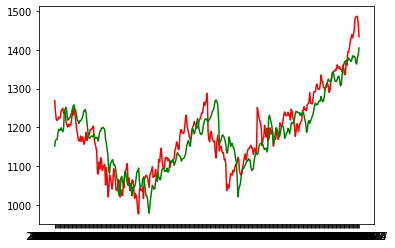

In [19]:
plt.plot(df_time, y_test,color='r',label='Price')
plt.plot(df_time, pre,color='g',label='predict')